# **Bitcoin**

## Import Libraries

In [2]:
import pandas as pd
import numpy as np
import datetime
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import TimeSeriesSplit

# metrics
from sklearn.metrics import make_scorer, mean_absolute_error, median_absolute_error, mean_squared_error
from sklearn.metrics import balanced_accuracy_score, precision_score, recall_score

# cross-validation
from sklearn.model_selection import train_test_split, cross_validate, cross_val_predict, GridSearchCV, RandomizedSearchCV

# preprocessing
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler, RobustScaler, StandardScaler

# regression models
from sklearn.dummy import DummyRegressor
from sklearn.linear_model import LinearRegression, Lasso, ElasticNet
from sklearn.neighbors import KNeighborsRegressor
from sklearn import tree
from sklearn.tree import DecisionTreeRegressor, plot_tree
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.svm import SVR

from tensorflow.keras.layers import Normalization, SimpleRNN, LSTM, GRU
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Dense, Normalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

## Data Cleaning

Call api for take the data

In [104]:
import requests

In [105]:
symbol = 'BTCUSDT'
tick_interval = '2h'

In [106]:
def get_candles(start='', symbol='BTCUSDT', tick_interval='2h', limit=1000):
    
    base_url = 'https://api.binance.com/'
    endpoint = 'api/v3/klines?'
    
    if start:
        query = 'symbol=' + symbol + '&interval=' + tick_interval + '&startTime=' + str(start) +'&limit='+str(limit)
    else:
        query = 'symbol=' + symbol + '&interval=' + tick_interval +'&limit='+str(limit)
        
    candles = requests.get(base_url + endpoint + query).json()
    
    return candles, candles[-1][6]  # return candles and last colse time in a tuple

def get_all_candles_from_start(symbol, tick_interval):  # devuelve una lista de velas, cada vela es una lista tb
    start=1502942400000  # 17 de agosto de 2017
    _, last_time = get_candles(start='', symbol=symbol , tick_interval=tick_interval, limit=1)
    candles = []
    while start < last_time:
        i_candles, next_hop = get_candles(start, symbol, tick_interval)
        candles = candles + i_candles
        start = next_hop
    return candles

In [107]:
candles = get_all_candles_from_start(symbol, tick_interval)

columns=['open_time','open', 'high', 'low','close','volume','close_time','quote','trades','takers_buy_base','takers_buy_quote','ignore']
df = pd.DataFrame(candles, columns=columns)
df

open_time            open            high             low  \
0      1502942400000   4261.48000000   4328.69000000   4261.32000000   
1      1502949600000   4330.29000000   4349.99000000   4287.41000000   
2      1502956800000   4333.32000000   4445.78000000   4333.32000000   
3      1502964000000   4441.10000000   4485.39000000   4399.81000000   
4      1502971200000   4436.06000000   4459.00000000   4411.00000000   
...              ...             ...             ...             ...   
27559  1701748800000  41829.98000000  41918.00000000  41724.75000000   
27560  1701756000000  41911.10000000  41919.08000000  41414.00000000   
27561  1701763200000  41528.00000000  41728.00000000  41420.00000000   
27562  1701770400000  41705.55000000  41758.77000000  41565.13000000   
27563  1701777600000  41726.09000000  41864.11000000  41694.00000000   

                close         volume     close_time               quote  \
0       4315.32000000    70.41592500  1502949599999     302670.96196053   
1       4349.99000000    11.67294000  1502956799999      50523.37096975   
2       4444.00000000    11.73643000  1502963999999      51458.85952932   
3       4427.30000000    51.88345200  1502971199999     231042.29822033   
4       4459.00000000    54.34483400  1502978399999     241103.15802063   
...               ...            ...            ...                 ...   
27559  41911.09000000  1670.53622000  1701755999999   69863035.35224590   
27560  41528.00000000  4831.57684000  1701763199999  200961967.19007840   
27561  41705.54000000  2719.06619000  1701770399999  113102276.96793730   
27562  41726.09000000  2563.16304000  1701777599999  106830010.77133510   
27563  41786.10000000  1258.65010000  1701784799999   52598994.99390740   

       trades takers_buy_base   takers_buy_quote ignore  
0         273     56.60857400    243560.75767140      0  
1          61      7.40515300     32086.66423939      0  
2          71     11.07305500     48548.12497460      0  
3         177     47.71457800    212505.92617935      0  
4         226     41.87703600    185858.30968151      0  
...       ...             ...                ...    ...  
27559   92522    877.45543000  36695932.50422930      0  
27560  164668   1921.19232000  79943375.99872620      0  
27561  124334   1342.83865000  55860335.67331080      0  
27562   98961   1214.70509000  50631074.56260810      0  
27563   45968    689.62354000  28819660.77755040      0  

[27564 rows x 12 columns]

Change the time for understand better

In [108]:
df['close_time'] = pd.to_datetime(df['close_time'], unit='ms')
df['close_time'] = df['close_time'].dt.tz_localize('utc').dt.tz_convert('Europe/Madrid')
df['open_time'] = pd.to_datetime(df['open_time'], unit='ms')
df['open_time'] = df['open_time'].dt.tz_localize('utc').dt.tz_convert('Europe/Madrid')

We add the target

In [109]:
df['target'] = df['close'].shift(-1).values
df.tail()

open_time            open            high  \
27559 2023-12-05 05:00:00+01:00  41829.98000000  41918.00000000   
27560 2023-12-05 07:00:00+01:00  41911.10000000  41919.08000000   
27561 2023-12-05 09:00:00+01:00  41528.00000000  41728.00000000   
27562 2023-12-05 11:00:00+01:00  41705.55000000  41758.77000000   
27563 2023-12-05 13:00:00+01:00  41726.09000000  41864.11000000   

                  low           close         volume  \
27559  41724.75000000  41911.09000000  1670.53622000   
27560  41414.00000000  41528.00000000  4831.57684000   
27561  41420.00000000  41705.54000000  2719.06619000   
27562  41565.13000000  41726.09000000  2563.16304000   
27563  41694.00000000  41786.10000000  1258.65010000   

                            close_time               quote  trades  \
27559 2023-12-05 06:59:59.999000+01:00   69863035.35224590   92522   
27560 2023-12-05 08:59:59.999000+01:00  200961967.19007840  164668   
27561 2023-12-05 10:59:59.999000+01:00  113102276.96793730  124334   
27562 2023-12-05 12:59:59.999000+01:00  106830010.77133510   98961   
27563 2023-12-05 14:59:59.999000+01:00   52598994.99390740   45968   

      takers_buy_base   takers_buy_quote ignore          target  
27559    877.45543000  36695932.50422930      0  41528.00000000  
27560   1921.19232000  79943375.99872620      0  41705.54000000  
27561   1342.83865000  55860335.67331080      0  41726.09000000  
27562   1214.70509000  50631074.56260810      0  41786.10000000  
27563    689.62354000  28819660.77755040      0            None

In [110]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 27564 entries, 0 to 27563
Data columns (total 13 columns):
 #   Column            Non-Null Count  Dtype                        
---  ------            --------------  -----                        
 0   open_time         27564 non-null  datetime64[ns, Europe/Madrid]
 1   open              27564 non-null  object                       
 2   high              27564 non-null  object                       
 3   low               27564 non-null  object                       
 4   close             27564 non-null  object                       
 5   volume            27564 non-null  object                       
 6   close_time        27564 non-null  datetime64[ns, Europe/Madrid]
 7   quote             27564 non-null  object                       
 8   trades            27564 non-null  int64                        
 9   takers_buy_base   27564 non-null  object                       
 10  takers_buy_quote  27564 non-null  object                  

### NaNs

In [111]:
# NaN values
nan_ser = df.isna().sum().sort_values(ascending=False)
nan_ser[nan_ser > 0]

target    1
dtype: int64

In [112]:
df.shape

(27564, 13)

In [113]:
df = df.dropna()
df.shape

(27563, 13)

### Duplicates

In [114]:
df.duplicated().any()

False

### Outliers

In [115]:
df.describe().T

count           mean            std  min      25%      50%  \
trades  27563.0  119985.941516  181673.296687  0.0  22937.5  56853.0   

             75%        max  
trades  128115.0  2708366.0

### Save CSV

In [116]:
df.to_csv('data/bitcoin_clean_data.csv', index=False)

## Exploratory Data Analysis (EDA)

- Outliers?
- Correlations?
- Consistency: do all values of the features and target make sense?
- Explore the data

### Load Data

In [103]:
df = pd.read_csv('data/bitcoin_clean_data.csv')

In [104]:
import plotly.express as px

In [110]:
Grafico = px.bar(df, x='close_time', y='close',
                     color='close',
                     template='gridon',
                     labels={'Fecha':'close_time', 'Valor':'close'},
                     title='Evolucion Bitcoin cada 2h',
                     height=550)
Grafico.show()

### Numerical features distribution

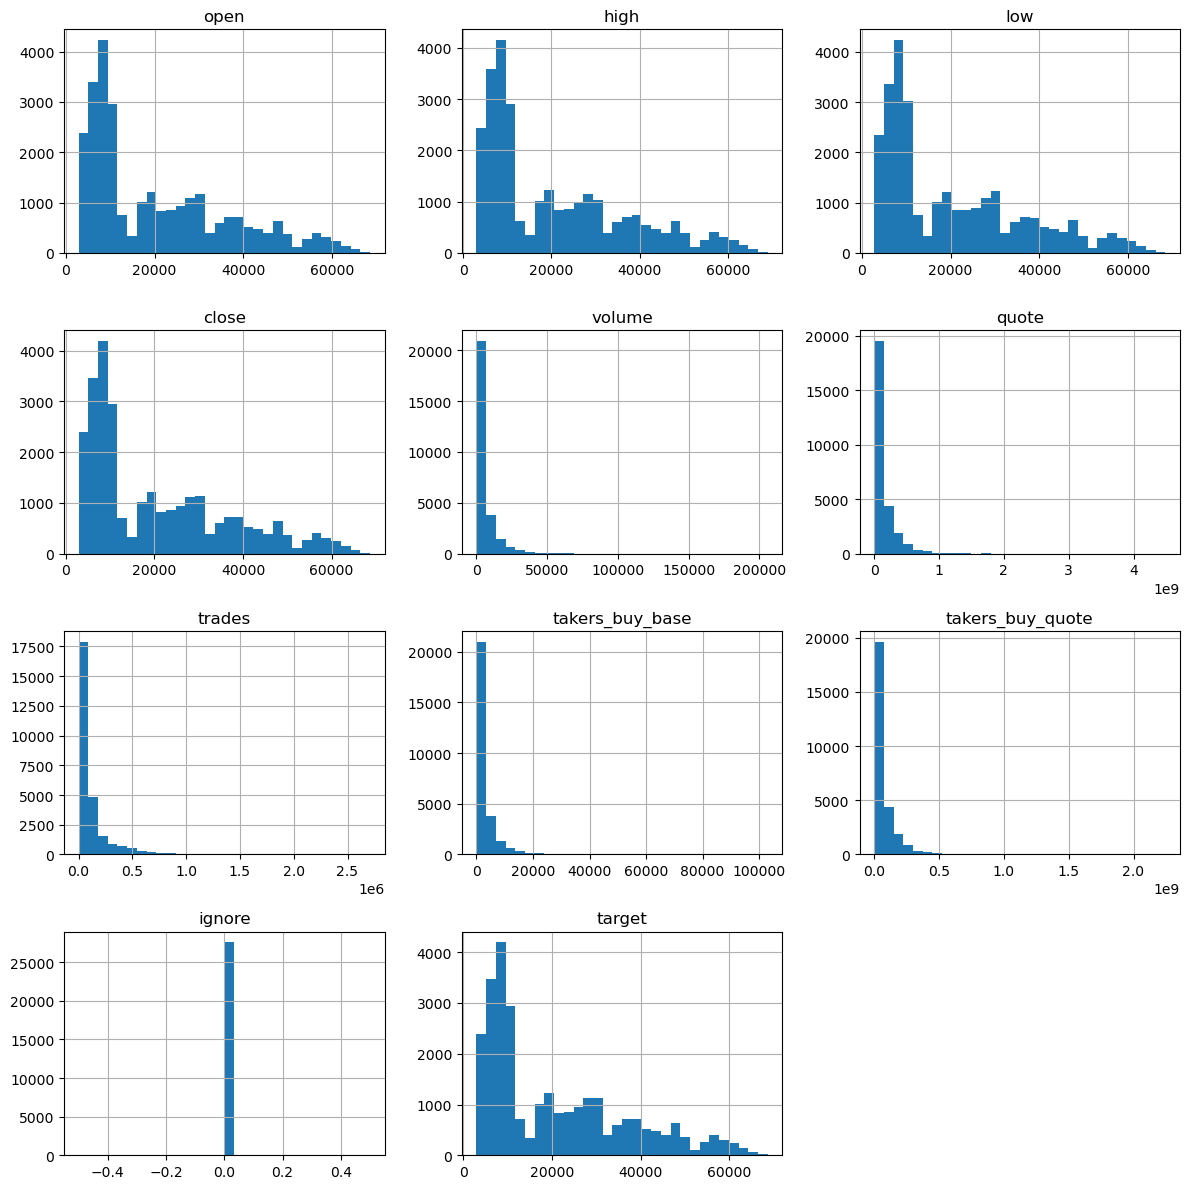

In [118]:
df.hist(bins=30, figsize=(12, 12))
plt.tight_layout()
plt.show()

### Categorical features distribution

In [119]:
# Categorical features
df.columns[df.dtypes == 'object']

Index(['open_time', 'close_time'], dtype='object')

### Correlation matrix

C:\Users\Alumne_mati1\AppData\Local\Temp\ipykernel_9460\3397144567.py:2: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  sns.heatmap(df.corr(), annot=True, fmt='.2f', cmap='coolwarm', linewidths=0.5, linecolor='white')


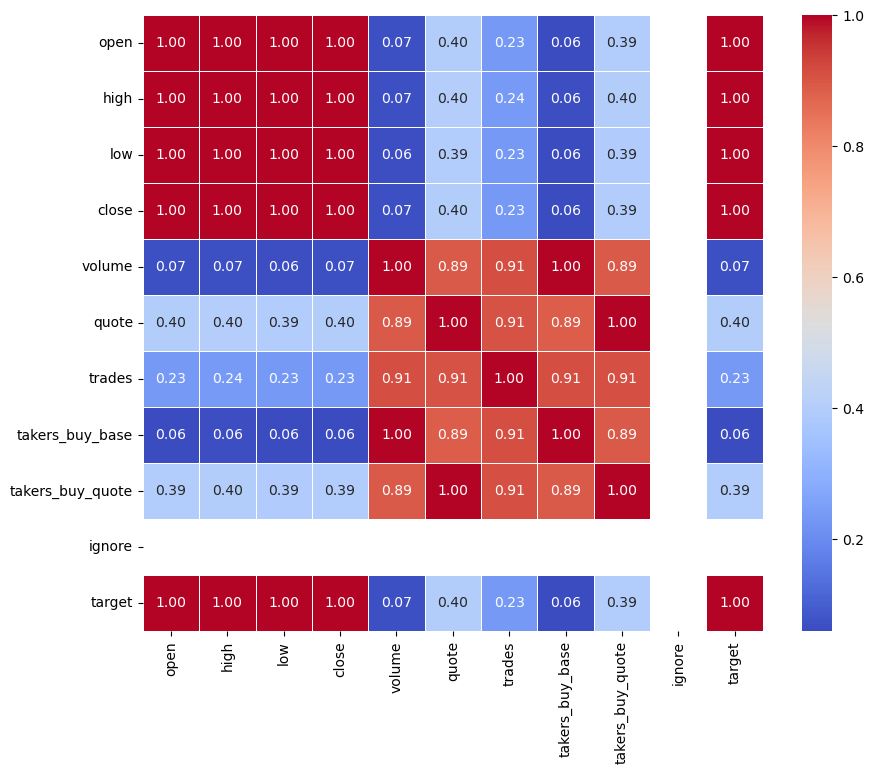

In [120]:
fig, ax = plt.subplots(figsize=(10, 8), dpi=100)
sns.heatmap(df.corr(), annot=True, fmt='.2f', cmap='coolwarm', linewidths=0.5, linecolor='white')

plt.show()

Is normal cause the price sometimes don't change a lot, and are very similar

### Pair Plot

In [121]:
# Numerical features
df.select_dtypes(include='number').columns

Index(['open', 'high', 'low', 'close', 'volume', 'quote', 'trades',
       'takers_buy_base', 'takers_buy_quote', 'ignore', 'target'],
      dtype='object')

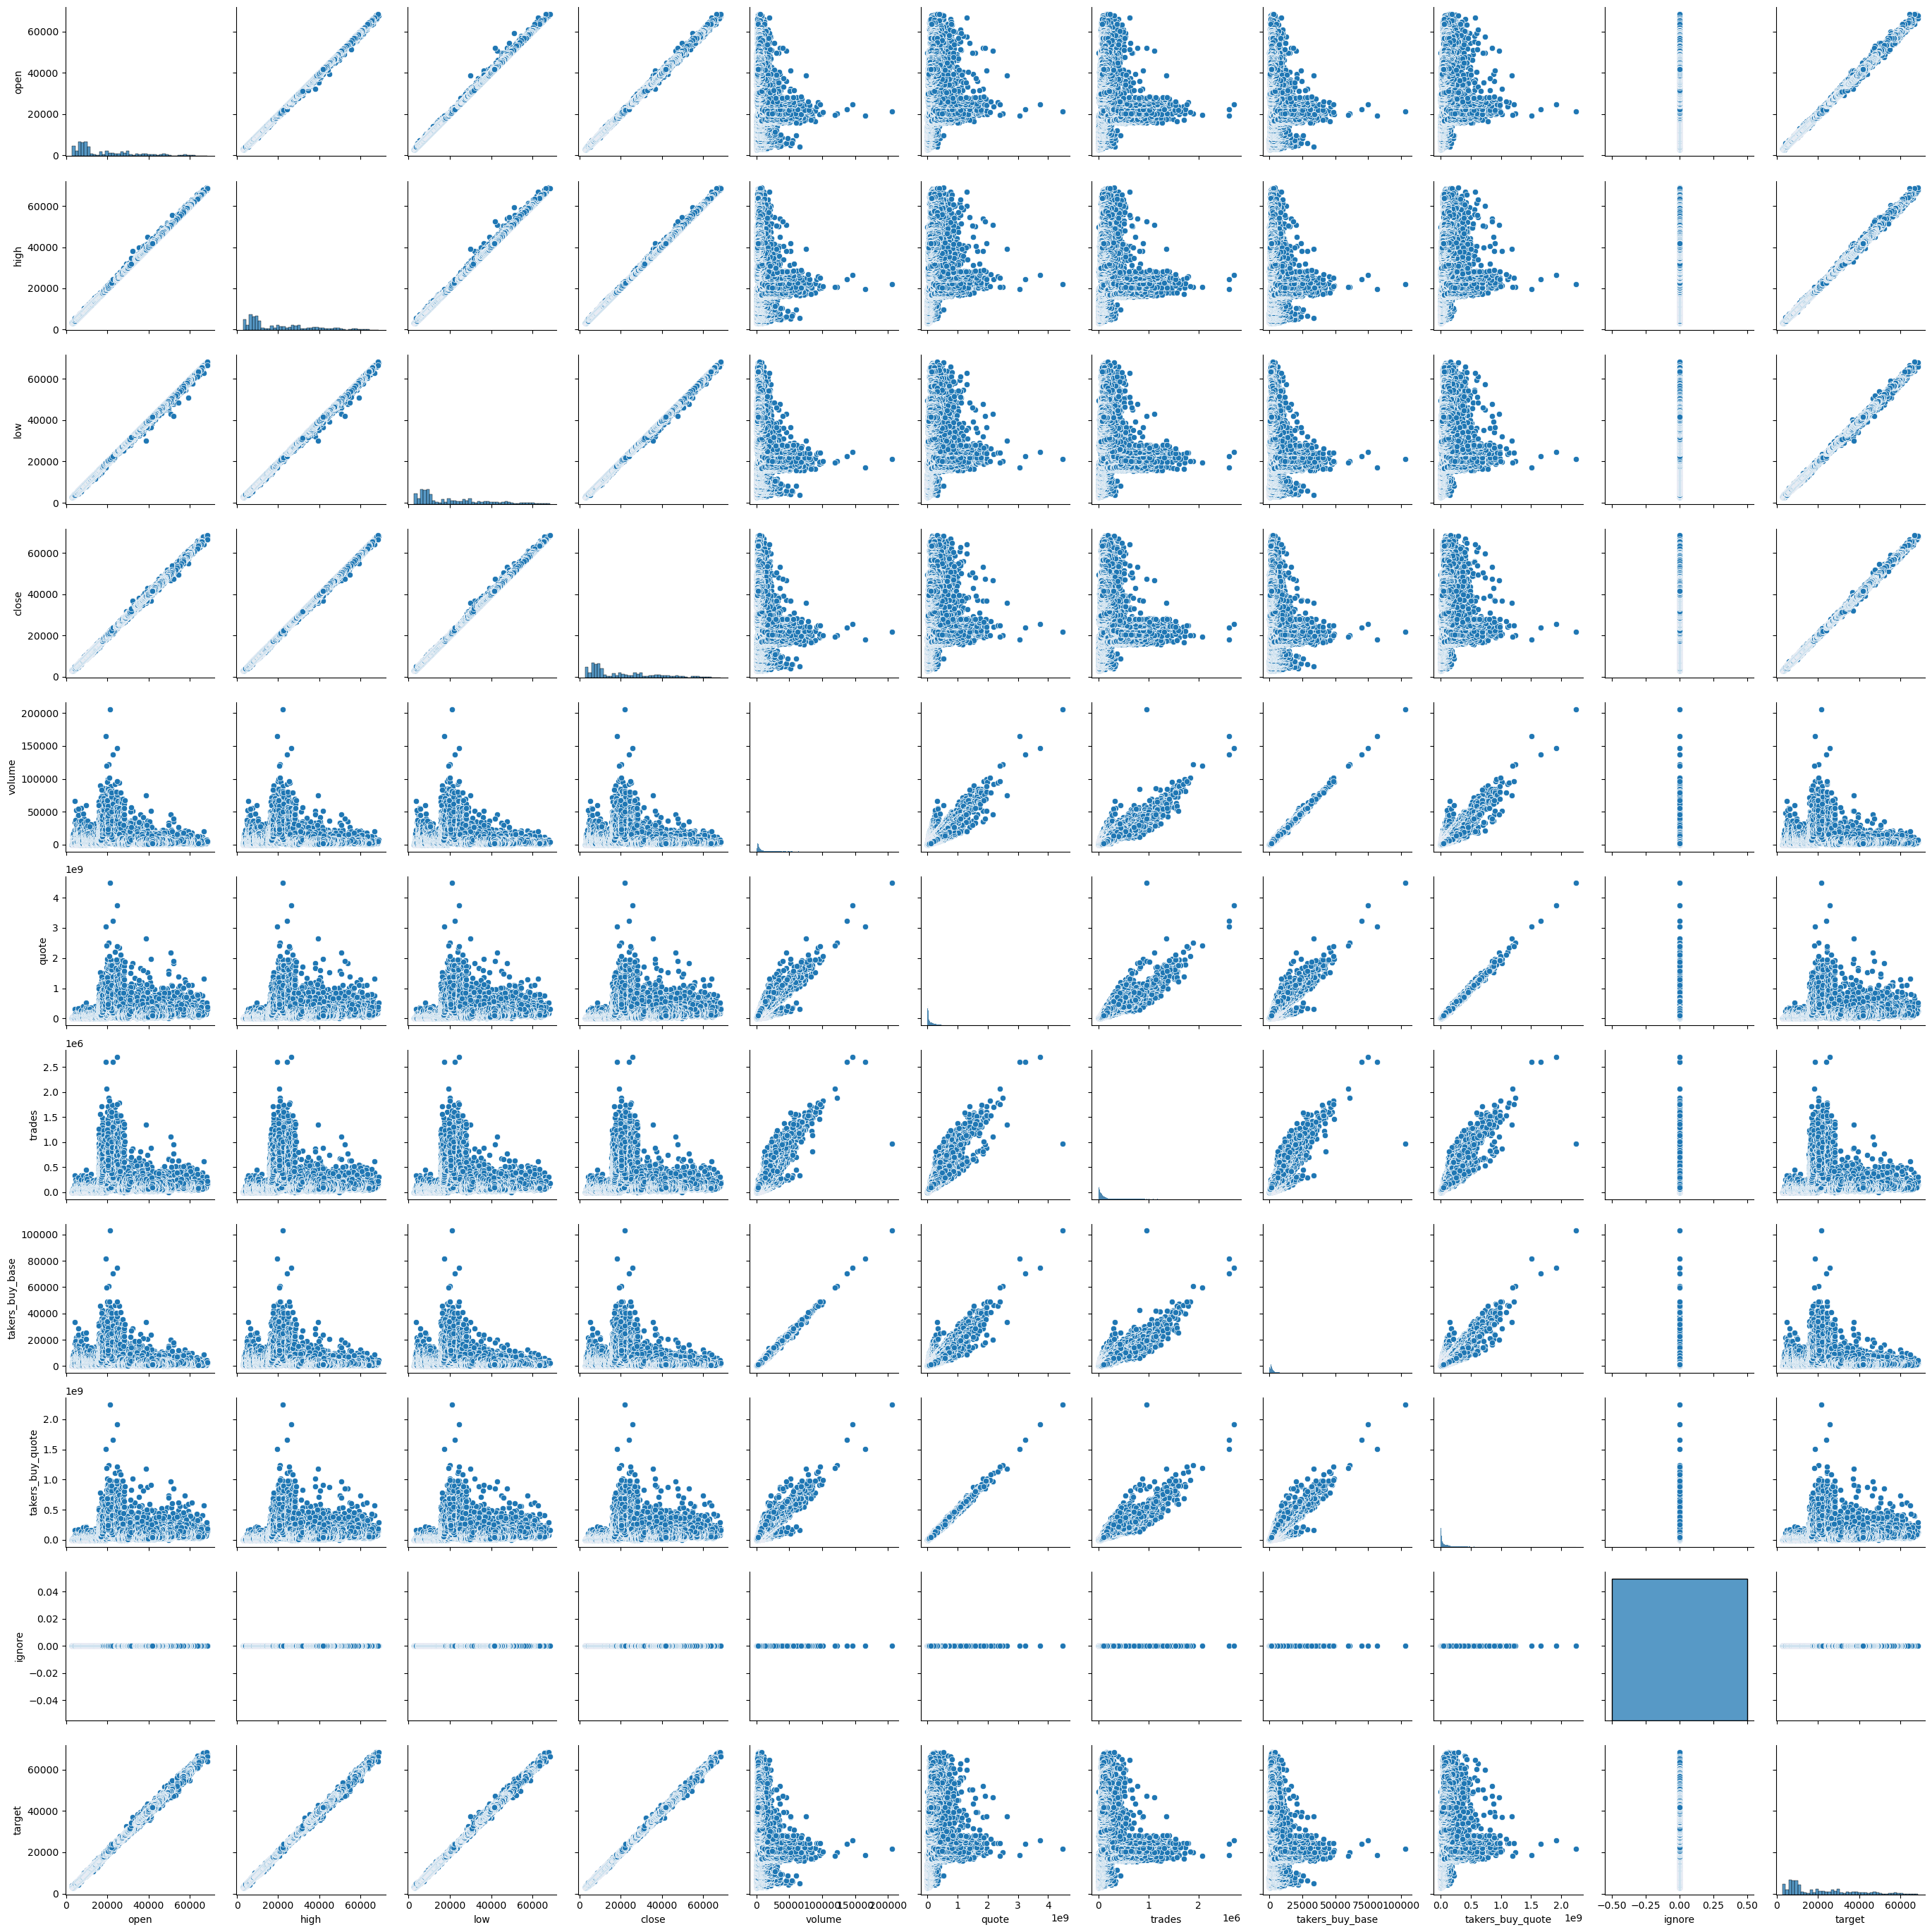

In [122]:
sns.pairplot(df)
plt.tight_layout()
plt.show()

### Correlation

In [123]:
# feature correlations with sale is_canceled
is_target = df.corr(numeric_only=True)['target'].sort_values(ascending=False)[1:].to_frame()

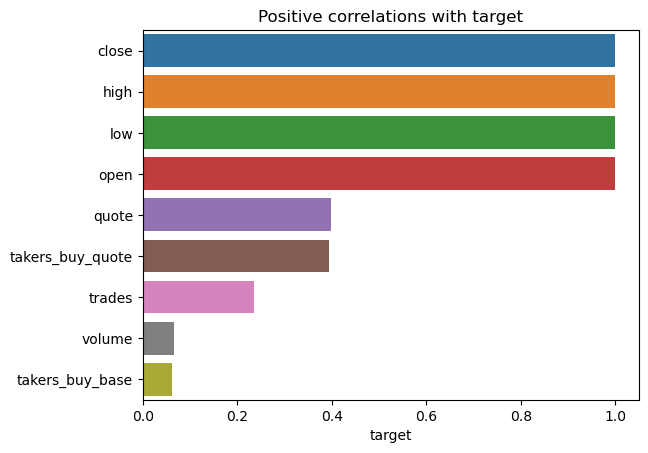

In [124]:
# positive correlations
pos_corrs = is_target[is_target['target'] >= 0]
sns.barplot(x='target', y=pos_corrs.index, data=pos_corrs)
plt.title('Positive correlations with target')
plt.show()

the correlation in open, hight, low and close is hight cause in 2h the price change a bit

## Feature engineering

- Remove unnecessary features
- Encode categorical features: Label Encoding, One-Hot Encoding, ...
- Correlations?
- New features?

In [125]:
df.head()

open_time     open     high      low    close     volume  \
0  2017-08-17 06:00:00+02:00  4261.48  4328.69  4261.32  4315.32  70.415925   
1  2017-08-17 08:00:00+02:00  4330.29  4349.99  4287.41  4349.99  11.672940   
2  2017-08-17 10:00:00+02:00  4333.32  4445.78  4333.32  4444.00  11.736430   
3  2017-08-17 12:00:00+02:00  4441.10  4485.39  4399.81  4427.30  51.883452   
4  2017-08-17 14:00:00+02:00  4436.06  4459.00  4411.00  4459.00  54.344834   

                         close_time          quote  trades  takers_buy_base  \
0  2017-08-17 07:59:59.999000+02:00  302670.961961     273        56.608574   
1  2017-08-17 09:59:59.999000+02:00   50523.370970      61         7.405153   
2  2017-08-17 11:59:59.999000+02:00   51458.859529      71        11.073055   
3  2017-08-17 13:59:59.999000+02:00  231042.298220     177        47.714578   
4  2017-08-17 15:59:59.999000+02:00  241103.158021     226        41.877036   

   takers_buy_quote  ignore   target  
0     243560.757671       0  4349.99  
1      32086.664239       0  4444.00  
2      48548.124975       0  4427.30  
3     212505.926179       0  4459.00  
4     185858.309682       0  4352.34

In [126]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 27563 entries, 0 to 27562
Data columns (total 13 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   open_time         27563 non-null  object 
 1   open              27563 non-null  float64
 2   high              27563 non-null  float64
 3   low               27563 non-null  float64
 4   close             27563 non-null  float64
 5   volume            27563 non-null  float64
 6   close_time        27563 non-null  object 
 7   quote             27563 non-null  float64
 8   trades            27563 non-null  int64  
 9   takers_buy_base   27563 non-null  float64
 10  takers_buy_quote  27563 non-null  float64
 11  ignore            27563 non-null  int64  
 12  target            27563 non-null  float64
dtypes: float64(9), int64(2), object(2)
memory usage: 2.7+ MB


### Remove unnecessary features

In [127]:
df.drop(['ignore'], axis=1, inplace=True)

### Missing Imputations

Nothing

### Categorical features

In [128]:
df.columns[df.dtypes == 'object']

Index(['open_time', 'close_time'], dtype='object')

In [129]:
df["open_time"].value_counts()

2017-08-17 06:00:00+02:00    1
2021-10-31 13:00:00+01:00    1
2021-10-31 09:00:00+01:00    1
2021-10-31 07:00:00+01:00    1
2021-10-31 05:00:00+01:00    1
                            ..
2019-09-25 02:00:00+02:00    1
2019-09-25 00:00:00+02:00    1
2019-09-24 22:00:00+02:00    1
2019-09-24 20:00:00+02:00    1
2023-12-05 11:00:00+01:00    1
Name: open_time, Length: 27563, dtype: int64

In [130]:
df["close_time"].value_counts()

2017-08-17 07:59:59.999000+02:00    1
2021-10-31 14:59:59.999000+01:00    1
2021-10-31 10:59:59.999000+01:00    1
2021-10-31 08:59:59.999000+01:00    1
2021-10-31 06:59:59.999000+01:00    1
                                   ..
2019-09-25 03:59:59.999000+02:00    1
2019-09-25 01:59:59.999000+02:00    1
2019-09-24 23:59:59.999000+02:00    1
2019-09-24 21:59:59.999000+02:00    1
2023-12-05 12:59:59.999000+01:00    1
Name: close_time, Length: 27563, dtype: int64

In [131]:
df['open_time'] = pd.to_datetime(df['open_time'], utc=True).dt.tz_convert('Europe/Madrid')
df['close_time'] = pd.to_datetime(df['close_time'], utc=True).dt.tz_convert('Europe/Madrid')

In [132]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 27563 entries, 0 to 27562
Data columns (total 12 columns):
 #   Column            Non-Null Count  Dtype                        
---  ------            --------------  -----                        
 0   open_time         27563 non-null  datetime64[ns, Europe/Madrid]
 1   open              27563 non-null  float64                      
 2   high              27563 non-null  float64                      
 3   low               27563 non-null  float64                      
 4   close             27563 non-null  float64                      
 5   volume            27563 non-null  float64                      
 6   close_time        27563 non-null  datetime64[ns, Europe/Madrid]
 7   quote             27563 non-null  float64                      
 8   trades            27563 non-null  int64                        
 9   takers_buy_base   27563 non-null  float64                      
 10  takers_buy_quote  27563 non-null  float64                 

#### One-hot encoding

Nothing

#### Ordinal Encoding

Nothing

### Correlations

In [133]:
# Get correlations between features without duplicates
corrs = df.corr().unstack().reset_index().drop_duplicates()
# Remove correlations between the same feature
corrs = corrs[corrs['level_0'] != corrs['level_1']]
# Get high correlations
corrs[(corrs[0] > 0.95) | (corrs[0] < -0.95)]

C:\Users\Alumne_mati1\AppData\Local\Temp\ipykernel_9460\2640382327.py:2: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corrs = df.corr().unstack().reset_index().drop_duplicates()


level_0           level_1         0
1               open              high  0.999909
2               open               low  0.999862
3               open             close  0.999841
9               open            target  0.999685
10              high              open  0.999909
12              high               low  0.999794
13              high             close  0.999912
19              high            target  0.999759
20               low              open  0.999862
21               low              high  0.999794
23               low             close  0.999896
29               low            target  0.999734
30             close              open  0.999841
31             close              high  0.999912
32             close               low  0.999896
39             close            target  0.999841
47            volume   takers_buy_base  0.998157
58             quote  takers_buy_quote  0.998131
74   takers_buy_base            volume  0.998157
85  takers_buy_quote             quote  0.998131
90            target              open  0.999685
91            target              high  0.999759
92            target               low  0.999734
93            target             close  0.999841

Is normal, the price change a bit in 2h

### New Features

First we want to try easy with no more features, after we add some features

### Save CSV

In [134]:
# Make sure all columns are numeric
assert df.drop(['open_time', 'close_time'], axis=1).select_dtypes(include='number').shape[1] == df.drop(['open_time', 'close_time'], axis=1).shape[1]

In [135]:
df.shape

(27563, 12)

In [136]:
df.to_csv('data/bitcoin_feature_engineering.csv', index=False)

## Machine Learning

In [3]:
df = pd.read_csv('data/bitcoin_feature_engineering.csv')
pd.options.display.max_columns = None   #para que muestren todas las columnas
df.head()

open_time     open     high      low    close     volume  \
0  2017-08-17 06:00:00+02:00  4261.48  4328.69  4261.32  4315.32  70.415925   
1  2017-08-17 08:00:00+02:00  4330.29  4349.99  4287.41  4349.99  11.672940   
2  2017-08-17 10:00:00+02:00  4333.32  4445.78  4333.32  4444.00  11.736430   
3  2017-08-17 12:00:00+02:00  4441.10  4485.39  4399.81  4427.30  51.883452   
4  2017-08-17 14:00:00+02:00  4436.06  4459.00  4411.00  4459.00  54.344834   

                         close_time          quote  trades  takers_buy_base  \
0  2017-08-17 07:59:59.999000+02:00  302670.961961     273        56.608574   
1  2017-08-17 09:59:59.999000+02:00   50523.370970      61         7.405153   
2  2017-08-17 11:59:59.999000+02:00   51458.859529      71        11.073055   
3  2017-08-17 13:59:59.999000+02:00  231042.298220     177        47.714578   
4  2017-08-17 15:59:59.999000+02:00  241103.158021     226        41.877036   

   takers_buy_quote   target  
0     243560.757671  4349.99  
1      32086.664239  4444.00  
2      48548.124975  4427.30  
3     212505.926179  4459.00  
4     185858.309682  4352.34

In [4]:
df.shape

(27563, 12)

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 27563 entries, 0 to 27562
Data columns (total 12 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   open_time         27563 non-null  object 
 1   open              27563 non-null  float64
 2   high              27563 non-null  float64
 3   low               27563 non-null  float64
 4   close             27563 non-null  float64
 5   volume            27563 non-null  float64
 6   close_time        27563 non-null  object 
 7   quote             27563 non-null  float64
 8   trades            27563 non-null  int64  
 9   takers_buy_base   27563 non-null  float64
 10  takers_buy_quote  27563 non-null  float64
 11  target            27563 non-null  float64
dtypes: float64(9), int64(1), object(2)
memory usage: 2.5+ MB


In [6]:
df['open_time'] = pd.to_datetime(df['open_time'], utc=True).dt.tz_convert('Europe/Madrid')
#df['close_time'] = pd.to_datetime(df['close_time'], utc=True, errors='coerce', format='mixed', dayfirst=True).dt.tz_convert('Europe/Madrid')
df['close_time'] = pd.to_datetime(df['close_time'], utc=True).dt.tz_convert('Europe/Madrid')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 27563 entries, 0 to 27562
Data columns (total 12 columns):
 #   Column            Non-Null Count  Dtype                        
---  ------            --------------  -----                        
 0   open_time         27563 non-null  datetime64[ns, Europe/Madrid]
 1   open              27563 non-null  float64                      
 2   high              27563 non-null  float64                      
 3   low               27563 non-null  float64                      
 4   close             27563 non-null  float64                      
 5   volume            27563 non-null  float64                      
 6   close_time        27563 non-null  datetime64[ns, Europe/Madrid]
 7   quote             27563 non-null  float64                      
 8   trades            27563 non-null  int64                        
 9   takers_buy_base   27563 non-null  float64                      
 10  takers_buy_quote  27563 non-null  float64                 

### Train / Test

In [7]:
X = df.drop(['open_time', 'close_time', 'target'], axis=1)
y = df['target']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

In [8]:
y_train

0         4349.99
1         4444.00
2         4427.30
3         4459.00
4         4352.34
           ...   
22045    19871.68
22046    20084.23
22047    20131.46
22048    20050.84
22049    20157.01
Name: target, Length: 22050, dtype: float64

### Cross-validation

In [9]:
scoring = {
    'MAE': make_scorer(mean_absolute_error),
    'MedAE': make_scorer(median_absolute_error),
    'MSE': make_scorer(mean_squared_error),
}

In [10]:
def custom_cv_ts(df, models, X, y, cv):
    """
    Perform time series cross-validation with a given model, X, y, and cv object.
    """
    # Create empty train and test MAE lists
    train_maes = []
    val_maes = []
    train_mse = []
    val_mse= []
    train_medae = []
    val_medae = []
    best_pa = []
    val_bacc = []
    val_rec = []
    val_prec = []
    

    # Cross-validation
    for i, (train_index, val_index) in enumerate(cv.split(X)):
        # Train and val data in this split
        X_train, y_train = X.iloc[train_index], y.iloc[train_index]
        X_val, y_val = X.iloc[val_index], y.iloc[val_index]

        # Nested train and validation data from previous train data
        X_train2, X_val2, y_train2, y_val2 = train_test_split(X_train, y_train, test_size=0.1,
                                                              random_state=42, shuffle=False)
        
        # Calculate validation metrics after training each model
        metrics = []
        for mod in models:
            mod.fit(X_train2, y_train2)
            y_pred_val2 = mod.predict(X_val2)
            metrics.append( mean_absolute_error(y_val2, y_pred_val2) )
            
        # Select the best model based on validation MAE and retrain it with the whole training data
        best_model_idx = np.argmin(metrics)
        best_model = models[best_model_idx]
        best_params = None
        best_model_str = type(best_model)
        if isinstance(best_model, RandomizedSearchCV) or \
           isinstance(best_model, GridSearchCV):
            best_params = best_model.best_params_
            if isinstance(best_model.best_estimator_, Pipeline):
                # Assuming the model is the 2nd element of the pipeline...
                best_model_str = type(best_model.best_estimator_[1])
            else:
                best_model_str = type(best_model.best_estimator_)
            print('Best validation model:', best_model_idx, f'({best_model_str})')
        if best_params is not None:
            print('Best params:', best_params)
        best_model.fit(X_train, y_train)

        y_diff = y_val2 - X_val2.close
        y_diff
        y_real_bin = pd.Series(np.zeros(len(y_val2)))
        y_real_bin.iloc[np.where(y_diff > 0)[0]] = 1

        #y_pred = lr.predict(X2_test)
        y_diff = y_pred_val2 - X_val2.close
        y_diff
        y_pred_bin = pd.Series(np.zeros(len(y_val2)))
        y_pred_bin.iloc[np.where(y_diff > 0)[0]] = 1        
        
        # Predict and compute MAEs of the train and val sets
        y_pred_train = best_model.predict(X_train)
        y_pred_val = best_model.predict(X_val)
        train_maes.append( mean_absolute_error(y_train, y_pred_train) )
        val_maes.append( mean_absolute_error(y_val, y_pred_val) )
        train_mse.append( mean_squared_error(y_train, y_pred_train) )
        val_mse.append( mean_squared_error(y_val, y_pred_val) )
        train_medae.append( median_absolute_error(y_train, y_pred_train) )
        val_medae.append( median_absolute_error(y_val, y_pred_val) )
        val_bacc.append(balanced_accuracy_score(y_real_bin, y_pred_bin))
        val_prec.append(precision_score(y_real_bin, y_pred_bin))
        val_rec.append(recall_score(y_real_bin, y_pred_bin))
        
        if isinstance(best_model, RandomizedSearchCV):        
            best_pa.append(best_model.best_params_)
                                    
        # Show info
        print(i)
        dates = df.loc[X.index, 'open_time']
        dates2 = df.loc[X.index, 'close_time']
        print('Best validation model:', best_model_idx)
        print('Train dates:', dates.iloc[train_index].min().date(), '-', dates.iloc[train_index].max().date())
        print('Train MAE:', round(train_maes[-1], 2))
        print('Train MSE:', round(train_mse[-1], 2))
        print('Train MedAE:', round(train_medae[-1], 2))
        
        print('Validation dates:', dates.iloc[val_index].min().date(), '-', dates.iloc[val_index].max().date())
        print('Validation MAE:', round(val_maes[-1], 2))
        print('Validation MSE:', round(val_mse[-1], 2))
        print('Validation MedAE:', round(val_medae[-1], 2))
        print('Validation BACC:', val_bacc[-1])
        print('Validation PREC:', val_prec[-1])
        print('Validation REC:', val_rec[-1])
        
        print()
        if isinstance(best_model, RandomizedSearchCV):  
            print("Best Parameters: ",best_model.best_params_)

    return np.array(train_maes), np.array(val_maes), np.array(train_mse), np.array(val_mse), np.array(train_medae), np.array(val_medae), np.array(best_pa), np.array(val_bacc), np.array(val_prec), np.array(val_rec),

### Baseline

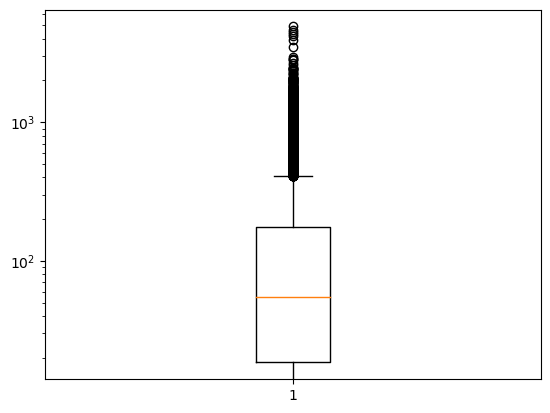

In [146]:
plt.boxplot(y_train.diff().abs().dropna())
plt.yscale('log')
plt.show()

In [147]:
# Diferencia entre un valor y otro, haciendo la media
y_train.diff().abs().mean()

155.2390439475713

### Linear Regression

In [91]:
# Create TimeSeriesSplit object
tscv = TimeSeriesSplit(n_splits=15, test_size=3)

# Models to try in each cross-validation split
models = [
    LinearRegression(n_jobs=-1),
]

train_maes, valid_maes, train_mse, valid_mse, train_medae, valid_medae, best_pa = custom_cv_ts(df, models, X_train, y_train, cv=tscv)

0
Best validation model: 0
Train dates: 2017-08-17 - 2022-08-29
Train MAE: 155.07
Train MSE: 92984.63
Train MedAE: 54.95
Validation dates: 2022-08-29 - 2022-08-29
Validation MAE: 150.38
Validation MSE: 32087.02
Validation MedAE: 174.85

1
Best validation model: 0
Train dates: 2017-08-17 - 2022-08-29
Train MAE: 155.07
Train MSE: 92976.32
Train MedAE: 54.96
Validation dates: 2022-08-29 - 2022-08-29
Validation MAE: 96.28
Validation MSE: 14312.59
Validation MedAE: 98.57

2
Best validation model: 0
Train dates: 2017-08-17 - 2022-08-29
Train MAE: 155.07
Train MSE: 92965.6
Train MedAE: 54.96
Validation dates: 2022-08-29 - 2022-08-30
Validation MAE: 104.17
Validation MSE: 11104.32
Validation MedAE: 105.49

3
Best validation model: 0
Train dates: 2017-08-17 - 2022-08-30
Train MAE: 155.06
Train MSE: 92954.44
Train MedAE: 54.98
Validation dates: 2022-08-30 - 2022-08-30
Validation MAE: 57.0
Validation MSE: 7041.92
Validation MedAE: 15.32

4
Best validation model: 0
Train dates: 2017-08-17 - 2022-0

In [92]:
print('Mean train MAE:', train_maes.mean().round(2), '$')
print('Mean validation MAE:', valid_maes.mean().round(2), '$')
print()
print('Mean train MSE:', train_mse.mean().round(2), '$')
print('Mean validation MSE:', valid_mse.mean().round(2), '$')
print()
print('Mean train MedAE:', train_medae.mean().round(2), '$')
print('Mean validation MedAE:', valid_medae.mean().round(2), '$')
print()
print(best_pa)

Mean train MAE: 155.05 $
Mean validation MAE: 125.86 $

Mean train MSE: 92923.9 $
Mean validation MSE: 26064.95 $

Mean train MedAE: 55.02 $
Mean validation MedAE: 111.72 $

[]


### K-Neighbours 

In [16]:
# Create TimeSeriesSplit object
tscv = TimeSeriesSplit(n_splits=15, test_size=3)

param_dist_knn = {
    "scale": [StandardScaler(), RobustScaler(), MinMaxScaler()],
    "knn__n_neighbors": [3, 5, 8, 10, 12, 15, 20],
    "knn__weights": ["uniform", "distance"],
    "knn__p": [1, 2]
}

knn = Pipeline([
    ('scale', None),
    ('knn', KNeighborsRegressor(n_jobs=-1))
])

# Models to try in each cross-validation split
models = [
    RandomizedSearchCV(knn, param_distributions=param_dist_knn,
                              return_train_score=True, cv=tscv,
                              n_iter= 50, n_jobs=-1)
]

train_maes, valid_maes, train_mse, valid_mse, train_medae, valid_medae, best_pa = custom_cv_ts(df, models, X_train, y_train, cv=tscv)

Best validation model: 0 (<class 'sklearn.neighbors._regression.KNeighborsRegressor'>)
Best params: {'scale': MinMaxScaler(), 'knn__weights': 'distance', 'knn__p': 1, 'knn__n_neighbors': 10}
0
Best validation model: 0
Train dates: 2017-08-17 - 2022-08-29
Train MAE: 157.1
Train MSE: 90738.42
Train MedAE: 59.27
Validation dates: 2022-08-29 - 2022-08-29
Validation MAE: 332.45
Validation MSE: 172792.07
Validation MedAE: 199.66

Best Parameters:  {'scale': MinMaxScaler(), 'knn__weights': 'uniform', 'knn__p': 1, 'knn__n_neighbors': 5}
Best validation model: 0 (<class 'sklearn.neighbors._regression.KNeighborsRegressor'>)
Best params: {'scale': MinMaxScaler(), 'knn__weights': 'distance', 'knn__p': 1, 'knn__n_neighbors': 10}
1
Best validation model: 0
Train dates: 2017-08-17 - 2022-08-29
Train MAE: 162.88
Train MSE: 98833.87
Train MedAE: 60.83
Validation dates: 2022-08-29 - 2022-08-29
Validation MAE: 420.3
Validation MSE: 213350.99
Validation MedAE: 500.83

Best Parameters:  {'scale': MinMaxSca

In [17]:
print('Mean train MAE:', train_maes.mean().round(2), 'ºC')
print('Mean validation MAE:', valid_maes.mean().round(2), 'ºC')
print()
print('Mean train MSE:', train_mse.mean().round(2), 'ºC')
print('Mean validation MSE:', valid_mse.mean().round(2), 'ºC')
print()
print('Mean train MedAE:', train_medae.mean().round(2), 'ºC')
print('Mean validation MedAE:', valid_medae.mean().round(2), 'ºC')
print()
print(best_pa)

Mean train MAE: 63.99 ºC
Mean validation MAE: 256.08 ºC

Mean train MSE: 37882.17 ºC
Mean validation MSE: 134466.94 ºC

Mean train MedAE: 24.03 ºC
Mean validation MedAE: 216.66 ºC

[{'scale': MinMaxScaler(), 'knn__weights': 'uniform', 'knn__p': 1, 'knn__n_neighbors': 5}
 {'scale': MinMaxScaler(), 'knn__weights': 'uniform', 'knn__p': 1, 'knn__n_neighbors': 8}
 {'scale': MinMaxScaler(), 'knn__weights': 'uniform', 'knn__p': 1, 'knn__n_neighbors': 5}
 {'scale': MinMaxScaler(), 'knn__weights': 'distance', 'knn__p': 1, 'knn__n_neighbors': 8}
 {'scale': MinMaxScaler(), 'knn__weights': 'uniform', 'knn__p': 1, 'knn__n_neighbors': 5}
 {'scale': MinMaxScaler(), 'knn__weights': 'distance', 'knn__p': 1, 'knn__n_neighbors': 8}
 {'scale': MinMaxScaler(), 'knn__weights': 'uniform', 'knn__p': 1, 'knn__n_neighbors': 8}
 {'scale': MinMaxScaler(), 'knn__weights': 'distance', 'knn__p': 1, 'knn__n_neighbors': 8}
 {'scale': MinMaxScaler(), 'knn__weights': 'distance', 'knn__p': 1, 'knn__n_neighbors': 8}
 {'sc

### Random Forest

In [20]:
# Create TimeSeriesSplit object
tscv = TimeSeriesSplit(n_splits=15, test_size=3)

param_dist_rf = {
    "max_depth": [3, 5, 10, 20, 50],
    "min_samples_split": np.arange(2, 30),
    "min_samples_leaf": np.arange(1, 11),
    "criterion": ["friedman_mse", "squared_error", "absolute_error"],
    "n_estimators": np.arange(2,200),
    "max_features": ["sqrt", "log2", 0.2, 0.4, 0.6, 0.8],  
}

rf = RandomForestRegressor(n_jobs=-1)

# Models to try in each cross-validation split
models = [
    RandomizedSearchCV(rf, param_distributions=param_dist_rf,
                             return_train_score=True, cv=tscv,
                             verbose=1, n_iter=50,
                             n_jobs=-1)
]

train_maes, valid_maes, train_mse, valid_mse, train_medae, valid_medae, best_pa = custom_cv_ts(df, models, X_train, y_train, cv=tscv)

Fitting 15 folds for each of 50 candidates, totalling 750 fits


Best validation model: 0 (<class 'sklearn.ensemble._forest.RandomForestRegressor'>)
Best params: {'n_estimators': 6, 'min_samples_split': 21, 'min_samples_leaf': 10, 'max_features': 0.6, 'max_depth': 5, 'criterion': 'squared_error'}
Fitting 15 folds for each of 50 candidates, totalling 750 fits
0
Best validation model: 0
Train dates: 2017-08-17 - 2022-08-29
Train MAE: 136.72
Train MSE: 70735.19
Train MedAE: 50.26
Validation dates: 2022-08-29 - 2022-08-29
Validation MAE: 138.28
Validation MSE: 28233.98
Validation MedAE: 141.5

Best Parameters:  {'n_estimators': 71, 'min_samples_split': 12, 'min_samples_leaf': 10, 'max_features': 0.8, 'max_depth': 10, 'criterion': 'friedman_mse'}
Fitting 15 folds for each of 50 candidates, totalling 750 fits
Best validation model: 0 (<class 'sklearn.ensemble._forest.RandomForestRegressor'>)
Best params: {'n_estimators': 18, 'min_samples_split': 21, 'min_samples_leaf': 7, 'max_features': 0.6, 'max_depth': 5, 'criterion': 'squared_error'}
Fitting 15 folds 

: 

In [ ]:
print('Mean train MAE:', train_maes.mean().round(2), 'ºC')
print('Mean validation MAE:', valid_maes.mean().round(2), 'ºC')
print()
print('Mean train MSE:', train_mse.mean().round(2), 'ºC')
print('Mean validation MSE:', valid_mse.mean().round(2), 'ºC')
print()
print('Mean train MedAE:', train_medae.mean().round(2), 'ºC')
print('Mean validation MedAE:', valid_medae.mean().round(2), 'ºC')
print()
print(best_pa)

### Gradient Boosting Decision Tree

In [18]:
# Create TimeSeriesSplit object
tscv = TimeSeriesSplit(n_splits=15, test_size=3)

param_dist_gb = {
    "max_depth": [3, 5, 10, 20, 50],
    "min_samples_split": np.arange(2, 30),
    "min_samples_leaf": np.arange(1, 11),
    "criterion": ["friedman_mse", "squared_error"],
    "n_estimators": np.arange(2,200),
    "max_features": ["sqrt", "log2", 0.2, 0.4, 0.6, 0.8], 
    "learning_rate": [ 0.08, 0.085, 0.09, 0.099]
}

gb = GradientBoostingRegressor()

# Models to try in each cross-validation split
models = [
    RandomizedSearchCV(gb, param_distributions=param_dist_gb,
                             return_train_score=True,
                             cv=tscv, verbose=1, n_iter=50,
                             n_jobs=-1)
]

train_maes, valid_maes, train_mse, valid_mse, train_medae, valid_medae, best_pa = custom_cv_ts(df, models, X_train, y_train, cv=tscv)

Fitting 15 folds for each of 50 candidates, totalling 750 fits


Best validation model: 0 (<class 'sklearn.ensemble._gb.GradientBoostingRegressor'>)
Best params: {'n_estimators': 128, 'min_samples_split': 9, 'min_samples_leaf': 3, 'max_features': 'sqrt', 'max_depth': 5, 'learning_rate': 0.08, 'criterion': 'friedman_mse'}
Fitting 15 folds for each of 50 candidates, totalling 750 fits
0
Best validation model: 0
Train dates: 2017-08-17 - 2022-08-29
Train MAE: 92.14
Train MSE: 25318.69
Train MedAE: 45.11
Validation dates: 2022-08-29 - 2022-08-29
Validation MAE: 103.62
Validation MSE: 19721.41
Validation MedAE: 74.06

Best Parameters:  {'n_estimators': 61, 'min_samples_split': 3, 'min_samples_leaf': 6, 'max_features': 0.8, 'max_depth': 10, 'learning_rate': 0.099, 'criterion': 'friedman_mse'}
Fitting 15 folds for each of 50 candidates, totalling 750 fits
Best validation model: 0 (<class 'sklearn.ensemble._gb.GradientBoostingRegressor'>)
Best params: {'n_estimators': 168, 'min_samples_split': 9, 'min_samples_leaf': 3, 'max_features': 0.4, 'max_depth': 3, '

In [19]:
print('Mean train MAE:', train_maes.mean().round(2), 'ºC')
print('Mean validation MAE:', valid_maes.mean().round(2), 'ºC')
print()
print('Mean train MSE:', train_mse.mean().round(2), 'ºC')
print('Mean validation MSE:', valid_mse.mean().round(2), 'ºC')
print()
print('Mean train MedAE:', train_medae.mean().round(2), 'ºC')
print('Mean validation MedAE:', valid_medae.mean().round(2), 'ºC')
print()
print(best_pa)

Mean train MAE: 475.8 ºC
Mean validation MAE: 142.05 ºC

Mean train MSE: 986078.16 ºC
Mean validation MSE: 33130.68 ºC

Mean train MedAE: 357.6 ºC
Mean validation MedAE: 128.68 ºC

[{'n_estimators': 61, 'min_samples_split': 3, 'min_samples_leaf': 6, 'max_features': 0.8, 'max_depth': 10, 'learning_rate': 0.099, 'criterion': 'friedman_mse'}
 {'n_estimators': 167, 'min_samples_split': 13, 'min_samples_leaf': 8, 'max_features': 'sqrt', 'max_depth': 10, 'learning_rate': 0.09, 'criterion': 'friedman_mse'}
 {'n_estimators': 24, 'min_samples_split': 29, 'min_samples_leaf': 3, 'max_features': 0.8, 'max_depth': 50, 'learning_rate': 0.09, 'criterion': 'squared_error'}
 {'n_estimators': 31, 'min_samples_split': 12, 'min_samples_leaf': 5, 'max_features': 0.8, 'max_depth': 10, 'learning_rate': 0.09, 'criterion': 'squared_error'}
 {'n_estimators': 19, 'min_samples_split': 5, 'min_samples_leaf': 2, 'max_features': 0.8, 'max_depth': 3, 'learning_rate': 0.09, 'criterion': 'friedman_mse'}
 {'n_estimators

### SVR

In [10]:
# Create TimeSeriesSplit object
tscv = TimeSeriesSplit(n_splits=15, test_size=3)

# Models to try in each cross-validation split
models = [
    SVR(max_iter=5000, kernel='linear', C=1.0, epsilon=0.1)
]

train_maes, valid_maes, train_mse, valid_mse, train_medae, valid_medae, best_pa = custom_cv_ts(df, models, X_train, y_train, cv=tscv)

c:\Users\Xavi\anaconda3\Lib\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=5000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
c:\Users\Xavi\anaconda3\Lib\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=5000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


0
Best validation model: 0
Train dates: 2017-08-17 - 2022-08-29
Train MAE: 115554.37
Train MSE: 13632905615.26
Train MedAE: 117069.85
Validation dates: 2022-08-29 - 2022-08-29
Validation MAE: 74864.31
Validation MSE: 5989350215.67
Validation MedAE: 85219.0



c:\Users\Xavi\anaconda3\Lib\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=5000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
c:\Users\Xavi\anaconda3\Lib\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=5000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


1
Best validation model: 0
Train dates: 2017-08-17 - 2022-08-29
Train MAE: 115548.82
Train MSE: 13631863691.13
Train MedAE: 117069.15
Validation dates: 2022-08-29 - 2022-08-29
Validation MAE: 63596.8
Validation MSE: 4197405715.23
Validation MedAE: 66522.17



c:\Users\Xavi\anaconda3\Lib\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=5000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
c:\Users\Xavi\anaconda3\Lib\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=5000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


2
Best validation model: 0
Train dates: 2017-08-17 - 2022-08-29
Train MAE: 115541.74
Train MSE: 13630577817.07
Train MedAE: 117067.76
Validation dates: 2022-08-29 - 2022-08-30
Validation MAE: 86130.81
Validation MSE: 7663251952.32
Validation MedAE: 82474.1



c:\Users\Xavi\anaconda3\Lib\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=5000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
c:\Users\Xavi\anaconda3\Lib\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=5000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


3
Best validation model: 0
Train dates: 2017-08-17 - 2022-08-30
Train MAE: 115537.73
Train MSE: 13629764608.31
Train MedAE: 117066.99
Validation dates: 2022-08-30 - 2022-08-30
Validation MAE: 79837.28
Validation MSE: 6561329729.57
Validation MedAE: 73218.79



c:\Users\Xavi\anaconda3\Lib\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=5000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
c:\Users\Xavi\anaconda3\Lib\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=5000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


4
Best validation model: 0
Train dates: 2017-08-17 - 2022-08-30
Train MAE: 115532.87
Train MSE: 13628801475.07
Train MedAE: 117066.71
Validation dates: 2022-08-30 - 2022-08-30
Validation MAE: 67931.3
Validation MSE: 4796055943.17
Validation MedAE: 76679.9



c:\Users\Xavi\anaconda3\Lib\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=5000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
c:\Users\Xavi\anaconda3\Lib\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=5000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


5
Best validation model: 0
Train dates: 2017-08-17 - 2022-08-30
Train MAE: 115526.38
Train MSE: 13627598103.74
Train MedAE: 117065.54
Validation dates: 2022-08-30 - 2022-08-30
Validation MAE: 27296.09
Validation MSE: 1163381006.98
Validation MedAE: 31629.58



c:\Users\Xavi\anaconda3\Lib\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=5000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
c:\Users\Xavi\anaconda3\Lib\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=5000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


6
Best validation model: 0
Train dates: 2017-08-17 - 2022-08-30
Train MAE: 115514.36
Train MSE: 13625900212.84
Train MedAE: 117065.37
Validation dates: 2022-08-30 - 2022-08-31
Validation MAE: 76923.87
Validation MSE: 5990197390.27
Validation MedAE: 80425.91



c:\Users\Xavi\anaconda3\Lib\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=5000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
c:\Users\Xavi\anaconda3\Lib\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=5000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


7
Best validation model: 0
Train dates: 2017-08-17 - 2022-08-31
Train MAE: 115509.11
Train MSE: 13624860209.74
Train MedAE: 117065.16
Validation dates: 2022-08-31 - 2022-08-31
Validation MAE: 74285.39
Validation MSE: 5540869136.05
Validation MedAE: 74842.26



c:\Users\Xavi\anaconda3\Lib\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=5000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
c:\Users\Xavi\anaconda3\Lib\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=5000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


8
Best validation model: 0
Train dates: 2017-08-17 - 2022-08-31
Train MAE: 115503.49
Train MSE: 13623759298.52
Train MedAE: 117063.58
Validation dates: 2022-08-31 - 2022-08-31
Validation MAE: 53003.66
Validation MSE: 3034898305.59
Validation MedAE: 59876.34



c:\Users\Xavi\anaconda3\Lib\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=5000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
c:\Users\Xavi\anaconda3\Lib\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=5000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


9
Best validation model: 0
Train dates: 2017-08-17 - 2022-08-31
Train MAE: 115494.98
Train MSE: 13622317460.15
Train MedAE: 117063.32
Validation dates: 2022-08-31 - 2022-08-31
Validation MAE: 49094.23
Validation MSE: 3013395133.99
Validation MedAE: 60291.12



c:\Users\Xavi\anaconda3\Lib\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=5000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
c:\Users\Xavi\anaconda3\Lib\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=5000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


10
Best validation model: 0
Train dates: 2017-08-17 - 2022-08-31
Train MAE: 115485.94
Train MSE: 13620873086.79
Train MedAE: 117062.93
Validation dates: 2022-08-31 - 2022-09-01
Validation MAE: 83730.14
Validation MSE: 7270055463.46
Validation MedAE: 78784.3



c:\Users\Xavi\anaconda3\Lib\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=5000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
c:\Users\Xavi\anaconda3\Lib\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=5000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


11
Best validation model: 0
Train dates: 2017-08-17 - 2022-09-01
Train MAE: 115481.62
Train MSE: 13620008559.48
Train MedAE: 117062.67
Validation dates: 2022-09-01 - 2022-09-01
Validation MAE: 72679.29
Validation MSE: 5445906103.98
Validation MedAE: 75399.32



c:\Users\Xavi\anaconda3\Lib\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=5000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
c:\Users\Xavi\anaconda3\Lib\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=5000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


12
Best validation model: 0
Train dates: 2017-08-17 - 2022-09-01
Train MAE: 115475.79
Train MSE: 13618895982.58
Train MedAE: 117062.31
Validation dates: 2022-09-01 - 2022-09-01
Validation MAE: 61069.48
Validation MSE: 3917902670.75
Validation MedAE: 65139.94



c:\Users\Xavi\anaconda3\Lib\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=5000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
c:\Users\Xavi\anaconda3\Lib\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=5000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


13
Best validation model: 0
Train dates: 2017-08-17 - 2022-09-01
Train MAE: 115468.39
Train MSE: 13617575760.3
Train MedAE: 117061.46
Validation dates: 2022-09-01 - 2022-09-01
Validation MAE: 46951.28
Validation MSE: 2567320660.93
Validation MedAE: 42701.2



c:\Users\Xavi\anaconda3\Lib\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=5000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


14
Best validation model: 0
Train dates: 2017-08-17 - 2022-09-01
Train MAE: 115459.06
Train MSE: 13616072119.66
Train MedAE: 117061.22
Validation dates: 2022-09-01 - 2022-09-02
Validation MAE: 89333.93
Validation MSE: 7984848215.03
Validation MedAE: 89107.65



c:\Users\Xavi\anaconda3\Lib\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=5000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


In [11]:
print('Mean train MAE:', train_maes.mean().round(2), 'ºC')
print('Mean validation MAE:', valid_maes.mean().round(2), 'ºC')
print()
print('Mean train MSE:', train_mse.mean().round(2), 'ºC')
print('Mean validation MSE:', valid_mse.mean().round(2), 'ºC')
print()
print('Mean train MedAE:', train_medae.mean().round(2), 'ºC')
print('Mean validation MedAE:', valid_medae.mean().round(2), 'ºC')
print()
print(best_pa)

Mean train MAE: 115508.98 ºC
Mean validation MAE: 67115.19 ºC

Mean train MSE: 13624784933.38 ºC
Mean validation MSE: 5009077842.87 ºC

Mean train MedAE: 117064.94 ºC
Mean validation MedAE: 69487.44 ºC

[]


### ElasticNet

In [14]:
# Create TimeSeriesSplit object
tscv = TimeSeriesSplit(n_splits=15, test_size=3)

en_pipe = Pipeline([
    ('scaler', None),
    ('en', ElasticNet(max_iter=100_000))
])

params = {
    'scaler': [MinMaxScaler(), RobustScaler(), StandardScaler()],
    'en__alpha': [0.1, 1, 10],
    'en__l1_ratio': [0.2, 0.5, 0.8],
}

# Models to try in each cross-validation split
models = [
    RandomizedSearchCV(en_pipe,
                           n_iter=50,
                           param_distributions=params,                           
                           cv=tscv,                           
                           return_train_score=True,
                           n_jobs=-1)
]

train_maes, valid_maes, train_mse, valid_mse, train_medae, valid_medae, best_pa = custom_cv_ts(df, models, X_train, y_train, cv=tscv)

c:\Users\Xavi\anaconda3\Lib\site-packages\sklearn\model_selection\_search.py:307: UserWarning: The total space of parameters 27 is smaller than n_iter=50. Running 27 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


Best validation model: 0 (<class 'sklearn.linear_model._coordinate_descent.ElasticNet'>)
Best params: {'scaler': StandardScaler(), 'en__l1_ratio': 0.8, 'en__alpha': 0.1}


c:\Users\Xavi\anaconda3\Lib\site-packages\sklearn\model_selection\_search.py:307: UserWarning: The total space of parameters 27 is smaller than n_iter=50. Running 27 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


0
Best validation model: 0
Train dates: 2017-08-17 - 2022-08-29
Train MAE: 208.72
Train MSE: 129632.73
Train MedAE: 110.89
Validation dates: 2022-08-29 - 2022-08-29
Validation MAE: 134.98
Validation MSE: 20026.92
Validation MedAE: 110.44

Best Parameters:  {'scaler': StandardScaler(), 'en__l1_ratio': 0.8, 'en__alpha': 0.1}


c:\Users\Xavi\anaconda3\Lib\site-packages\sklearn\model_selection\_search.py:307: UserWarning: The total space of parameters 27 is smaller than n_iter=50. Running 27 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


Best validation model: 0 (<class 'sklearn.linear_model._coordinate_descent.ElasticNet'>)
Best params: {'scaler': StandardScaler(), 'en__l1_ratio': 0.8, 'en__alpha': 0.1}


c:\Users\Xavi\anaconda3\Lib\site-packages\sklearn\model_selection\_search.py:307: UserWarning: The total space of parameters 27 is smaller than n_iter=50. Running 27 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


1
Best validation model: 0
Train dates: 2017-08-17 - 2022-08-29
Train MAE: 208.71
Train MSE: 129618.6
Train MedAE: 110.87
Validation dates: 2022-08-29 - 2022-08-29
Validation MAE: 152.41
Validation MSE: 35544.93
Validation MedAE: 116.96

Best Parameters:  {'scaler': StandardScaler(), 'en__l1_ratio': 0.8, 'en__alpha': 0.1}


c:\Users\Xavi\anaconda3\Lib\site-packages\sklearn\model_selection\_search.py:307: UserWarning: The total space of parameters 27 is smaller than n_iter=50. Running 27 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


Best validation model: 0 (<class 'sklearn.linear_model._coordinate_descent.ElasticNet'>)
Best params: {'scaler': StandardScaler(), 'en__l1_ratio': 0.8, 'en__alpha': 0.1}


c:\Users\Xavi\anaconda3\Lib\site-packages\sklearn\model_selection\_search.py:307: UserWarning: The total space of parameters 27 is smaller than n_iter=50. Running 27 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


2
Best validation model: 0
Train dates: 2017-08-17 - 2022-08-29
Train MAE: 9484.11
Train MSE: 123474838.24
Train MedAE: 8019.24
Validation dates: 2022-08-29 - 2022-08-30
Validation MAE: 329.76
Validation MSE: 117262.84
Validation MedAE: 308.46

Best Parameters:  {'scaler': MinMaxScaler(), 'en__l1_ratio': 0.5, 'en__alpha': 1}


c:\Users\Xavi\anaconda3\Lib\site-packages\sklearn\model_selection\_search.py:307: UserWarning: The total space of parameters 27 is smaller than n_iter=50. Running 27 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


Best validation model: 0 (<class 'sklearn.linear_model._coordinate_descent.ElasticNet'>)
Best params: {'scaler': StandardScaler(), 'en__l1_ratio': 0.8, 'en__alpha': 0.1}


c:\Users\Xavi\anaconda3\Lib\site-packages\sklearn\model_selection\_search.py:307: UserWarning: The total space of parameters 27 is smaller than n_iter=50. Running 27 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


3
Best validation model: 0
Train dates: 2017-08-17 - 2022-08-30
Train MAE: 9483.34
Train MSE: 123470018.45
Train MedAE: 8019.19
Validation dates: 2022-08-30 - 2022-08-30
Validation MAE: 399.96
Validation MSE: 167058.92
Validation MedAE: 351.85

Best Parameters:  {'scaler': MinMaxScaler(), 'en__l1_ratio': 0.5, 'en__alpha': 1}


c:\Users\Xavi\anaconda3\Lib\site-packages\sklearn\model_selection\_search.py:307: UserWarning: The total space of parameters 27 is smaller than n_iter=50. Running 27 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


Best validation model: 0 (<class 'sklearn.linear_model._coordinate_descent.ElasticNet'>)
Best params: {'scaler': StandardScaler(), 'en__l1_ratio': 0.8, 'en__alpha': 0.1}


c:\Users\Xavi\anaconda3\Lib\site-packages\sklearn\model_selection\_search.py:307: UserWarning: The total space of parameters 27 is smaller than n_iter=50. Running 27 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


4
Best validation model: 0
Train dates: 2017-08-17 - 2022-08-30
Train MAE: 9482.58
Train MSE: 123465192.82
Train MedAE: 8019.25
Validation dates: 2022-08-30 - 2022-08-30
Validation MAE: 318.96
Validation MSE: 106859.14
Validation MedAE: 368.11

Best Parameters:  {'scaler': MinMaxScaler(), 'en__l1_ratio': 0.5, 'en__alpha': 1}


c:\Users\Xavi\anaconda3\Lib\site-packages\sklearn\model_selection\_search.py:307: UserWarning: The total space of parameters 27 is smaller than n_iter=50. Running 27 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


Best validation model: 0 (<class 'sklearn.linear_model._coordinate_descent.ElasticNet'>)
Best params: {'scaler': StandardScaler(), 'en__l1_ratio': 0.8, 'en__alpha': 0.1}


c:\Users\Xavi\anaconda3\Lib\site-packages\sklearn\model_selection\_search.py:307: UserWarning: The total space of parameters 27 is smaller than n_iter=50. Running 27 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


5
Best validation model: 0
Train dates: 2017-08-17 - 2022-08-30
Train MAE: 208.67
Train MSE: 129562.36
Train MedAE: 110.99
Validation dates: 2022-08-30 - 2022-08-30
Validation MAE: 243.63
Validation MSE: 90839.37
Validation MedAE: 133.38

Best Parameters:  {'scaler': StandardScaler(), 'en__l1_ratio': 0.8, 'en__alpha': 0.1}


c:\Users\Xavi\anaconda3\Lib\site-packages\sklearn\model_selection\_search.py:307: UserWarning: The total space of parameters 27 is smaller than n_iter=50. Running 27 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


Best validation model: 0 (<class 'sklearn.linear_model._coordinate_descent.ElasticNet'>)
Best params: {'scaler': StandardScaler(), 'en__l1_ratio': 0.8, 'en__alpha': 0.1}


c:\Users\Xavi\anaconda3\Lib\site-packages\sklearn\model_selection\_search.py:307: UserWarning: The total space of parameters 27 is smaller than n_iter=50. Running 27 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


6
Best validation model: 0
Train dates: 2017-08-17 - 2022-08-30
Train MAE: 208.67
Train MSE: 129546.14
Train MedAE: 111.05
Validation dates: 2022-08-30 - 2022-08-31
Validation MAE: 263.17
Validation MSE: 75037.91
Validation MedAE: 236.15

Best Parameters:  {'scaler': StandardScaler(), 'en__l1_ratio': 0.8, 'en__alpha': 0.1}


c:\Users\Xavi\anaconda3\Lib\site-packages\sklearn\model_selection\_search.py:307: UserWarning: The total space of parameters 27 is smaller than n_iter=50. Running 27 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


Best validation model: 0 (<class 'sklearn.linear_model._coordinate_descent.ElasticNet'>)
Best params: {'scaler': StandardScaler(), 'en__l1_ratio': 0.8, 'en__alpha': 0.1}


c:\Users\Xavi\anaconda3\Lib\site-packages\sklearn\model_selection\_search.py:307: UserWarning: The total space of parameters 27 is smaller than n_iter=50. Running 27 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


7
Best validation model: 0
Train dates: 2017-08-17 - 2022-08-31
Train MAE: 208.68
Train MSE: 129541.39
Train MedAE: 111.04
Validation dates: 2022-08-31 - 2022-08-31
Validation MAE: 206.06
Validation MSE: 47509.9
Validation MedAE: 193.21

Best Parameters:  {'scaler': StandardScaler(), 'en__l1_ratio': 0.8, 'en__alpha': 0.1}


c:\Users\Xavi\anaconda3\Lib\site-packages\sklearn\model_selection\_search.py:307: UserWarning: The total space of parameters 27 is smaller than n_iter=50. Running 27 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


Best validation model: 0 (<class 'sklearn.linear_model._coordinate_descent.ElasticNet'>)
Best params: {'scaler': StandardScaler(), 'en__l1_ratio': 0.8, 'en__alpha': 0.1}


c:\Users\Xavi\anaconda3\Lib\site-packages\sklearn\model_selection\_search.py:307: UserWarning: The total space of parameters 27 is smaller than n_iter=50. Running 27 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


8
Best validation model: 0
Train dates: 2017-08-17 - 2022-08-31
Train MAE: 208.68
Train MSE: 129525.35
Train MedAE: 111.09
Validation dates: 2022-08-31 - 2022-08-31
Validation MAE: 146.54
Validation MSE: 39621.5
Validation MedAE: 70.56

Best Parameters:  {'scaler': StandardScaler(), 'en__l1_ratio': 0.8, 'en__alpha': 0.1}


c:\Users\Xavi\anaconda3\Lib\site-packages\sklearn\model_selection\_search.py:307: UserWarning: The total space of parameters 27 is smaller than n_iter=50. Running 27 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


Best validation model: 0 (<class 'sklearn.linear_model._coordinate_descent.ElasticNet'>)
Best params: {'scaler': StandardScaler(), 'en__l1_ratio': 0.8, 'en__alpha': 0.1}


c:\Users\Xavi\anaconda3\Lib\site-packages\sklearn\model_selection\_search.py:307: UserWarning: The total space of parameters 27 is smaller than n_iter=50. Running 27 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


9
Best validation model: 0
Train dates: 2017-08-17 - 2022-08-31
Train MAE: 208.66
Train MSE: 129507.61
Train MedAE: 111.13
Validation dates: 2022-08-31 - 2022-08-31
Validation MAE: 149.73
Validation MSE: 42162.99
Validation MedAE: 70.86

Best Parameters:  {'scaler': StandardScaler(), 'en__l1_ratio': 0.8, 'en__alpha': 0.1}


c:\Users\Xavi\anaconda3\Lib\site-packages\sklearn\model_selection\_search.py:307: UserWarning: The total space of parameters 27 is smaller than n_iter=50. Running 27 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


Best validation model: 0 (<class 'sklearn.linear_model._coordinate_descent.ElasticNet'>)
Best params: {'scaler': StandardScaler(), 'en__l1_ratio': 0.8, 'en__alpha': 0.1}


c:\Users\Xavi\anaconda3\Lib\site-packages\sklearn\model_selection\_search.py:307: UserWarning: The total space of parameters 27 is smaller than n_iter=50. Running 27 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


10
Best validation model: 0
Train dates: 2017-08-17 - 2022-08-31
Train MAE: 208.66
Train MSE: 129490.91
Train MedAE: 111.12
Validation dates: 2022-08-31 - 2022-09-01
Validation MAE: 149.17
Validation MSE: 25075.6
Validation MedAE: 122.76

Best Parameters:  {'scaler': StandardScaler(), 'en__l1_ratio': 0.8, 'en__alpha': 0.1}


c:\Users\Xavi\anaconda3\Lib\site-packages\sklearn\model_selection\_search.py:307: UserWarning: The total space of parameters 27 is smaller than n_iter=50. Running 27 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


Best validation model: 0 (<class 'sklearn.linear_model._coordinate_descent.ElasticNet'>)
Best params: {'scaler': StandardScaler(), 'en__l1_ratio': 0.8, 'en__alpha': 0.1}


c:\Users\Xavi\anaconda3\Lib\site-packages\sklearn\model_selection\_search.py:307: UserWarning: The total space of parameters 27 is smaller than n_iter=50. Running 27 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


11
Best validation model: 0
Train dates: 2017-08-17 - 2022-09-01
Train MAE: 208.64
Train MSE: 129474.86
Train MedAE: 111.13
Validation dates: 2022-09-01 - 2022-09-01
Validation MAE: 131.72
Validation MSE: 20203.34
Validation MedAE: 94.15

Best Parameters:  {'scaler': StandardScaler(), 'en__l1_ratio': 0.8, 'en__alpha': 0.1}


c:\Users\Xavi\anaconda3\Lib\site-packages\sklearn\model_selection\_search.py:307: UserWarning: The total space of parameters 27 is smaller than n_iter=50. Running 27 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


Best validation model: 0 (<class 'sklearn.linear_model._coordinate_descent.ElasticNet'>)
Best params: {'scaler': StandardScaler(), 'en__l1_ratio': 0.8, 'en__alpha': 0.1}


c:\Users\Xavi\anaconda3\Lib\site-packages\sklearn\model_selection\_search.py:307: UserWarning: The total space of parameters 27 is smaller than n_iter=50. Running 27 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


12
Best validation model: 0
Train dates: 2017-08-17 - 2022-09-01
Train MAE: 208.63
Train MSE: 129457.32
Train MedAE: 111.1
Validation dates: 2022-09-01 - 2022-09-01
Validation MAE: 178.65
Validation MSE: 44819.45
Validation MedAE: 122.42

Best Parameters:  {'scaler': StandardScaler(), 'en__l1_ratio': 0.8, 'en__alpha': 0.1}


c:\Users\Xavi\anaconda3\Lib\site-packages\sklearn\model_selection\_search.py:307: UserWarning: The total space of parameters 27 is smaller than n_iter=50. Running 27 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


Best validation model: 0 (<class 'sklearn.linear_model._coordinate_descent.ElasticNet'>)
Best params: {'scaler': StandardScaler(), 'en__l1_ratio': 0.8, 'en__alpha': 0.1}


c:\Users\Xavi\anaconda3\Lib\site-packages\sklearn\model_selection\_search.py:307: UserWarning: The total space of parameters 27 is smaller than n_iter=50. Running 27 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


13
Best validation model: 0
Train dates: 2017-08-17 - 2022-09-01
Train MAE: 208.62
Train MSE: 129441.72
Train MedAE: 111.11
Validation dates: 2022-09-01 - 2022-09-01
Validation MAE: 162.05
Validation MSE: 34866.52
Validation MedAE: 189.0

Best Parameters:  {'scaler': StandardScaler(), 'en__l1_ratio': 0.8, 'en__alpha': 0.1}


c:\Users\Xavi\anaconda3\Lib\site-packages\sklearn\model_selection\_search.py:307: UserWarning: The total space of parameters 27 is smaller than n_iter=50. Running 27 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


Best validation model: 0 (<class 'sklearn.linear_model._coordinate_descent.ElasticNet'>)
Best params: {'scaler': StandardScaler(), 'en__l1_ratio': 0.8, 'en__alpha': 0.1}


c:\Users\Xavi\anaconda3\Lib\site-packages\sklearn\model_selection\_search.py:307: UserWarning: The total space of parameters 27 is smaller than n_iter=50. Running 27 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


14
Best validation model: 0
Train dates: 2017-08-17 - 2022-09-01
Train MAE: 208.61
Train MSE: 129426.0
Train MedAE: 111.11
Validation dates: 2022-09-01 - 2022-09-02
Validation MAE: 61.58
Validation MSE: 4431.67
Validation MedAE: 49.74

Best Parameters:  {'scaler': StandardScaler(), 'en__l1_ratio': 0.8, 'en__alpha': 0.1}


In [15]:
print('Mean train MAE:', train_maes.mean().round(2), 'ºC')
print('Mean validation MAE:', valid_maes.mean().round(2), 'ºC')
print()
print('Mean train MSE:', train_mse.mean().round(2), 'ºC')
print('Mean validation MSE:', valid_mse.mean().round(2), 'ºC')
print()
print('Mean train MedAE:', train_medae.mean().round(2), 'ºC')
print('Mean validation MedAE:', valid_medae.mean().round(2), 'ºC')
print()
print(best_pa)

Mean train MAE: 2063.6 ºC
Mean validation MAE: 201.89 ºC

Mean train MSE: 24797618.3 ºC
Mean validation MSE: 58088.07 ºC

Mean train MedAE: 1692.69 ºC
Mean validation MedAE: 169.2 ºC

[{'scaler': StandardScaler(), 'en__l1_ratio': 0.8, 'en__alpha': 0.1}
 {'scaler': StandardScaler(), 'en__l1_ratio': 0.8, 'en__alpha': 0.1}
 {'scaler': MinMaxScaler(), 'en__l1_ratio': 0.5, 'en__alpha': 1}
 {'scaler': MinMaxScaler(), 'en__l1_ratio': 0.5, 'en__alpha': 1}
 {'scaler': MinMaxScaler(), 'en__l1_ratio': 0.5, 'en__alpha': 1}
 {'scaler': StandardScaler(), 'en__l1_ratio': 0.8, 'en__alpha': 0.1}
 {'scaler': StandardScaler(), 'en__l1_ratio': 0.8, 'en__alpha': 0.1}
 {'scaler': StandardScaler(), 'en__l1_ratio': 0.8, 'en__alpha': 0.1}
 {'scaler': StandardScaler(), 'en__l1_ratio': 0.8, 'en__alpha': 0.1}
 {'scaler': StandardScaler(), 'en__l1_ratio': 0.8, 'en__alpha': 0.1}
 {'scaler': StandardScaler(), 'en__l1_ratio': 0.8, 'en__alpha': 0.1}
 {'scaler': StandardScaler(), 'en__l1_ratio': 0.8, 'en__alpha': 0.1}


### Best Models

In [29]:
# Create TimeSeriesSplit object
tscv = TimeSeriesSplit(n_splits=15, test_size=3)

knn = Pipeline([
    ('scale', MinMaxScaler()),
    ('knn', KNeighborsRegressor(n_neighbors=8, p=1, n_jobs=-1, weights='distance'))
])

en_pipe = Pipeline([
    ('scaler', StandardScaler()),
    ('en', ElasticNet(max_iter=100_000,l1_ratio=0.8, alpha=0.1))
])

# Models to try in each cross-validation split
models = [
   LinearRegression(n_jobs=-1),
   knn,
   GradientBoostingRegressor(max_depth=5, learning_rate=0.09, criterion='friedman_mse', n_estimators=100, min_samples_leaf=5, min_samples_split=15, max_features=0.8),
   en_pipe
]


train_maes, valid_maes, train_mse, valid_mse, train_medae, valid_medae, best_pa = custom_cv_ts(df, models, X_train, y_train, cv=tscv)

0
Best validation model: 0
Train dates: 2017-08-17 - 2022-08-29
Train MAE: 155.07
Train MSE: 92984.63
Train MedAE: 54.95
Validation dates: 2022-08-29 - 2022-08-29
Validation MAE: 150.38
Validation MSE: 32087.02
Validation MedAE: 174.85

1
Best validation model: 0
Train dates: 2017-08-17 - 2022-08-29
Train MAE: 155.07
Train MSE: 92976.32
Train MedAE: 54.96
Validation dates: 2022-08-29 - 2022-08-29
Validation MAE: 96.28
Validation MSE: 14312.59
Validation MedAE: 98.57

2
Best validation model: 0
Train dates: 2017-08-17 - 2022-08-29
Train MAE: 155.07
Train MSE: 92965.6
Train MedAE: 54.96
Validation dates: 2022-08-29 - 2022-08-30
Validation MAE: 104.17
Validation MSE: 11104.32
Validation MedAE: 105.49

3
Best validation model: 0
Train dates: 2017-08-17 - 2022-08-30
Train MAE: 155.06
Train MSE: 92954.44
Train MedAE: 54.98
Validation dates: 2022-08-30 - 2022-08-30
Validation MAE: 57.0
Validation MSE: 7041.92
Validation MedAE: 15.32

4
Best validation model: 0
Train dates: 2017-08-17 - 2022-0

In [30]:
print('Mean train MAE:', train_maes.mean().round(2), '$')
print('Mean validation MAE:', valid_maes.mean().round(2), '$')
print()
print('Mean train MSE:', train_mse.mean().round(2), '$')
print('Mean validation MSE:', valid_mse.mean().round(2), '$')
print()
print('Mean train MedAE:', train_medae.mean().round(2), '$')
print('Mean validation MedAE:', valid_medae.mean().round(2), '$')
print()
print(best_pa)

Mean train MAE: 155.05 $
Mean validation MAE: 125.86 $

Mean train MSE: 92923.9 $
Mean validation MSE: 26064.95 $

Mean train MedAE: 55.02 $
Mean validation MedAE: 111.72 $

[]


### RNNs

In [11]:
def create_data_for_rnns(X, y, look_back=4):
    dataX, dataY = [], []
    for i in range(len(X) - look_back):
        # Take sequence of length `look_back`
        seqX = X.iloc[i:(i + look_back)].values
        seqY = y.iloc[i:(i + look_back)].values
        dataX.append(seqX)
        dataY.append(seqY)
    return np.array(dataX), np.array(dataY)

In [12]:
X_train_rnn, y_train_rnn = create_data_for_rnns(X_train, y_train, look_back=3)

# Añadir corrección para que tenga el mismo tamaño que X_train_raw
# de esta manera, la validación cruzada se aplicará en los mismos días que antes
X_train_rnn = np.concatenate((X_train_rnn, np.zeros((3, 3, X_train_rnn.shape[2]))), axis=0)
y_train_rnn = np.concatenate((y_train_rnn, np.zeros((3, 3))), axis=0)

pd.DataFrame(X_train_rnn[1], columns=X_train.columns)

open     high      low    close     volume          quote  trades  \
0  4330.29  4349.99  4287.41  4349.99  11.672940   50523.370970    61.0   
1  4333.32  4445.78  4333.32  4444.00  11.736430   51458.859529    71.0   
2  4441.10  4485.39  4399.81  4427.30  51.883452  231042.298220   177.0   

   takers_buy_base  takers_buy_quote  
0         7.405153      32086.664239  
1        11.073055      48548.124975  
2        47.714578     212505.926179

#### Adapt TS CV function

In [ ]:
y_diff = y_val - X_val.close
y_diff
y_real_bin = pd.Series(np.zeros(len(y_val)))
y_real_bin.iloc[np.where(y_diff > 0)[0]] = 1

y_pred = best_model.predict(X_val)
y_diff = y_pred - X_val.close
y_diff
y_pred_bin = pd.Series(np.zeros(len(y_val)))
y_pred_bin.iloc[np.where(y_diff > 0)[0]] = 1

In [71]:

def custom_cv_ts_rnn(df, models, X, y, cv, fit_hyperparams={}, dates=None):
    """
    Perform time series cross-validation with a given model, X, y, and cv object.
    """
    # Create empty train and test MAE lists
    train_maes = []
    val_maes = []
    val_bacc = []
    val_rec = []
    val_prec = []

    # Cross-validation
    for i, (train_index, val_index) in enumerate(cv.split(X)):
        # Train and val data in this split
        X_train, y_train = X[train_index], y[train_index]
        X_val, y_val = X[val_index], y[val_index]
        
        # Calculate validation metrics after training each model
        best_model_idx = 0
        if len(models) > 1:
            # Nested train and validation data from previous train data
            X_train2, X_val2, y_train2, y_val2 = train_test_split(X_train, y_train, test_size=0.1,
                                                                random_state=42, shuffle=False)
            metrics = []
            for mod in models:
                mod.fit(X_train2, y_train2, **fit_hyperparams)
                metrics.append( mod.evaluate(X_val2, y_val2, verbose=0) )
            # Select the best model based on validation MAE and retrain it with the whole training data
            best_model_idx = np.argmin(metrics)
        
        best_model = models[best_model_idx]
        best_model.fit(X_train, y_train, **fit_hyperparams)

        '''y_diff = y_val - X_val.close
        y_diff
        y_real_bin = pd.Series(np.zeros(len(y_val)))
        y_real_bin.iloc[np.where(y_diff > 0)[0]] = 1

        y_pred = best_model.predict(X_val)
        y_diff = y_pred - X_val.close
        y_diff
        y_pred_bin = pd.Series(np.zeros(len(y_val)))
        y_pred_bin.iloc[np.where(y_diff > 0)[0]] = 1 '''
        
        # Predict and compute MAEs of the train and val sets
        train_maes.append( best_model.evaluate(X_train, y_train, verbose=0) )
        val_maes.append( best_model.evaluate(X_val, y_val, verbose=0) )
        #val_bacc.append(balanced_accuracy_score(y_real_bin, y_pred_bin))
        #val_prec.append(precision_score(y_real_bin, y_pred_bin))
        #val_rec.append(recall_score(y_real_bin, y_pred_bin))
                                    
        # Show info
        if dates is not None:
            print('Best validation model:', best_model_idx)
            print('Train dates:', dates.iloc[train_index].min().date(), '-', dates.iloc[train_index].max().date())
            print('Train MAE:', round(train_maes[-1], 2))
            print('Validation dates:', dates.iloc[val_index].min().date(), '-', dates.iloc[val_index].max().date())
            print('Validation MAE:', round(val_maes[-1], 2))
            #print('Validation BACC:', val_bacc[-1])
            #print('Validation PREC:', val_prec[-1])
            #print('Validation REC:', val_rec[-1])
            #print()

    return np.array(train_maes), np.array(val_maes) #, np.array(val_bacc), np.array(val_prec),np.array(val_rec),

In [14]:
dates = df.loc[X_train.index, 'open_time']  

#### Simple

In [16]:
rnn = Sequential([
    Input(shape=(X_train_rnn.shape[1], X_train_rnn.shape[2])),
    Normalization(),
    SimpleRNN(64, activation='tanh', return_sequences=True),
    SimpleRNN(64, activation='tanh', return_sequences=False),
    Dense(8, activation='relu'),
    Dense(1, activation='linear')
])
rnn.compile(optimizer=Adam(learning_rate=0.0005), loss='mae')
es = EarlyStopping(patience=15, monitor='loss', restore_best_weights=True)

In [21]:
# Models to try in each cross-validation split
models = [rnn]
fit_hyperparams = {
    'epochs': 500,
    'batch_size': 128,
    'validation_split': 0.25,
    'callbacks': [es],
    'verbose': 0,
}

train_maes, valid_maes = custom_cv_ts_rnn(df, models, X_train_rnn, y_train_rnn, cv=tscv,
                                          fit_hyperparams=fit_hyperparams, dates=dates)

Best validation model: 0
Train dates: 2017-08-17 - 2022-08-29
Train MAE: 12378.15
Validation dates: 2022-08-29 - 2022-08-29
Validation MAE: 10884.85

Best validation model: 0
Train dates: 2017-08-17 - 2022-08-29
Train MAE: 12385.27
Validation dates: 2022-08-29 - 2022-08-29
Validation MAE: 10955.5

Best validation model: 0
Train dates: 2017-08-17 - 2022-08-29
Train MAE: 12393.53
Validation dates: 2022-08-29 - 2022-08-30
Validation MAE: 11083.1

Best validation model: 0
Train dates: 2017-08-17 - 2022-08-30
Train MAE: 12367.42
Validation dates: 2022-08-30 - 2022-08-30
Validation MAE: 11092.45

Best validation model: 0
Train dates: 2017-08-17 - 2022-08-30
Train MAE: 12409.04
Validation dates: 2022-08-30 - 2022-08-30
Validation MAE: 10770.22

Best validation model: 0
Train dates: 2017-08-17 - 2022-08-30
Train MAE: 12374.06
Validation dates: 2022-08-30 - 2022-08-30
Validation MAE: 10618.16

Best validation model: 0
Train dates: 2017-08-17 - 2022-08-30
Train MAE: 12374.98
Validation dates: 20

In [22]:
print('Mean train MAE:', train_maes.mean().round(2), '$')
print('Mean validation MAE:', valid_maes.mean().round(2), '$')
print('Median validation MAE:', np.median(valid_maes).round(2), '$')

Mean train MAE: 12380.06 $
Mean validation MAE: 10512.58 $
Median validation MAE: 10884.85 $


#### LSTM

In [23]:
lstm = Sequential([
    Input(shape=(X_train_rnn.shape[1], X_train_rnn.shape[2])),
    Normalization(),
    LSTM(32, return_sequences=True),
    LSTM(16, return_sequences=False),
    Dense(8, activation='relu'),
    Dense(4, activation='relu'),
    Dense(1, activation='linear')
])

lstm.compile(optimizer=Adam(learning_rate=0.001), loss='mae')
es = EarlyStopping(patience=15, monitor='loss', restore_best_weights=True)

In [24]:
# Models to try in each cross-validation split
models = [lstm]
fit_hyperparams = {
    'epochs': 500,
    'batch_size': 128,
    'validation_split': 0.25,
    'callbacks': [es],
    'verbose': 0,
}

train_maes, valid_maes = custom_cv_ts_rnn(df, models, X_train_rnn, y_train_rnn, cv=tscv,
                                          fit_hyperparams=fit_hyperparams, dates=dates)

Best validation model: 0
Train dates: 2017-08-17 - 2022-08-29
Train MAE: 12675.11
Validation dates: 2022-08-29 - 2022-08-29
Validation MAE: 11522.53

Best validation model: 0
Train dates: 2017-08-17 - 2022-08-29
Train MAE: 12654.67
Validation dates: 2022-08-29 - 2022-08-29
Validation MAE: 11608.4

Best validation model: 0
Train dates: 2017-08-17 - 2022-08-29
Train MAE: 12588.77
Validation dates: 2022-08-29 - 2022-08-30
Validation MAE: 11394.36

Best validation model: 0
Train dates: 2017-08-17 - 2022-08-30
Train MAE: 12590.51
Validation dates: 2022-08-30 - 2022-08-30
Validation MAE: 11507.75

Best validation model: 0
Train dates: 2017-08-17 - 2022-08-30
Train MAE: 12627.09
Validation dates: 2022-08-30 - 2022-08-30
Validation MAE: 11209.36

Best validation model: 0
Train dates: 2017-08-17 - 2022-08-30
Train MAE: 12594.78
Validation dates: 2022-08-30 - 2022-08-30
Validation MAE: 11024.28

Best validation model: 0
Train dates: 2017-08-17 - 2022-08-30
Train MAE: 12639.76
Validation dates: 2

In [25]:
print('Mean train MAE:', train_maes.mean().round(2), '$')
print('Mean validation MAE:', valid_maes.mean().round(2), '$')
print('Median validation MAE:', np.median(valid_maes).round(2), '$')

Mean train MAE: 12627.5 $
Mean validation MAE: 10853.98 $
Median validation MAE: 11363.88 $


#### GRU

In [74]:
gru = Sequential([
    Input(shape=(X_train_rnn.shape[1], X_train_rnn.shape[2])),
    Normalization(),
    GRU(32, return_sequences=True),
    #GRU(32, return_sequences=True),
    GRU(16, return_sequences=False),
    Dense(8, activation='relu'),
    Dense(4, activation='relu'),
    Dense(1, activation='linear')
])
gru.compile(optimizer=Adam(learning_rate=0.001), loss='mae')
es = EarlyStopping(patience=15, monitor='loss', restore_best_weights=True)

In [75]:
# Create TimeSeriesSplit object
tscv = TimeSeriesSplit(n_splits=15, test_size=3)

# Models to try in each cross-validation split
models = [gru]
fit_hyperparams = {
    'epochs': 500,
    'batch_size': 248,
    'validation_split': 0.25,
    'callbacks': [es],
    'verbose': 0,
}

train_maes, valid_maes = custom_cv_ts_rnn(df, models, X_train_rnn, y_train_rnn, cv=tscv,
                                          fit_hyperparams=fit_hyperparams, dates=dates)

Best validation model: 0
Train dates: 2017-08-17 - 2022-08-29
Train MAE: 12580.79
Validation dates: 2022-08-29 - 2022-08-29
Validation MAE: 11314.46
Best validation model: 0
Train dates: 2017-08-17 - 2022-08-29
Train MAE: 12560.97
Validation dates: 2022-08-29 - 2022-08-29
Validation MAE: 11279.34
Best validation model: 0
Train dates: 2017-08-17 - 2022-08-29
Train MAE: 12602.44
Validation dates: 2022-08-29 - 2022-08-30
Validation MAE: 11544.39
Best validation model: 0
Train dates: 2017-08-17 - 2022-08-30
Train MAE: 12587.6
Validation dates: 2022-08-30 - 2022-08-30
Validation MAE: 11595.42
Best validation model: 0
Train dates: 2017-08-17 - 2022-08-30
Train MAE: 12581.45
Validation dates: 2022-08-30 - 2022-08-30
Validation MAE: 11116.13
Best validation model: 0
Train dates: 2017-08-17 - 2022-08-30
Train MAE: 12579.71
Validation dates: 2022-08-30 - 2022-08-30
Validation MAE: 11064.47
Best validation model: 0
Train dates: 2017-08-17 - 2022-08-30
Train MAE: 12590.83
Validation dates: 2022-08

In [76]:
print('Mean train MAE:', train_maes.mean().round(2), '$')
print('Mean validation MAE:', valid_maes.mean().round(2), '$')
print('Median validation MAE:', np.median(valid_maes).round(2), '$')

Mean train MAE: 12574.49 $
Mean validation MAE: 11024.88 $
Median validation MAE: 11279.34 $


### New features

In [15]:
df2 = df
df2

open_time      open      high       low     close  \
0     2017-08-17 06:00:00+02:00   4261.48   4328.69   4261.32   4315.32   
1     2017-08-17 08:00:00+02:00   4330.29   4349.99   4287.41   4349.99   
2     2017-08-17 10:00:00+02:00   4333.32   4445.78   4333.32   4444.00   
3     2017-08-17 12:00:00+02:00   4441.10   4485.39   4399.81   4427.30   
4     2017-08-17 14:00:00+02:00   4436.06   4459.00   4411.00   4459.00   
...                         ...       ...       ...       ...       ...   
27558 2023-12-05 03:00:00+01:00  41805.06  41837.12  41622.21  41829.99   
27559 2023-12-05 05:00:00+01:00  41829.98  41918.00  41724.75  41911.09   
27560 2023-12-05 07:00:00+01:00  41911.10  41919.08  41414.00  41528.00   
27561 2023-12-05 09:00:00+01:00  41528.00  41728.00  41420.00  41705.54   
27562 2023-12-05 11:00:00+01:00  41705.55  41758.77  41565.13  41726.09   

            volume                       close_time         quote  trades  \
0        70.415925 2017-08-17 07:59:59.999000+02:00  3.026710e+05     273   
1        11.672940 2017-08-17 09:59:59.999000+02:00  5.052337e+04      61   
2        11.736430 2017-08-17 11:59:59.999000+02:00  5.145886e+04      71   
3        51.883452 2017-08-17 13:59:59.999000+02:00  2.310423e+05     177   
4        54.344834 2017-08-17 15:59:59.999000+02:00  2.411032e+05     226   
...            ...                              ...           ...     ...   
27558  2296.006960 2023-12-05 04:59:59.999000+01:00  9.585156e+07  107881   
27559  1670.536220 2023-12-05 06:59:59.999000+01:00  6.986304e+07   92522   
27560  4831.576840 2023-12-05 08:59:59.999000+01:00  2.009620e+08  164668   
27561  2719.066190 2023-12-05 10:59:59.999000+01:00  1.131023e+08  124334   
27562  2563.163040 2023-12-05 12:59:59.999000+01:00  1.068300e+08   98961   

       takers_buy_base  takers_buy_quote    target  
0            56.608574      2.435608e+05   4349.99  
1             7.405153      3.208666e+04   4444.00  
2            11.073055      4.854812e+04   4427.30  
3            47.714578      2.125059e+05   4459.00  
4            41.877036      1.858583e+05   4352.34  
...                ...               ...       ...  
27558      1123.809550      4.691284e+07  41911.09  
27559       877.455430      3.669593e+07  41528.00  
27560      1921.192320      7.994338e+07  41705.54  
27561      1342.838650      5.586034e+07  41726.09  
27562      1214.705090      5.063107e+07  41786.10  

[27563 rows x 12 columns]

In [16]:
df2['open_time'] = pd.to_datetime(df2['open_time'], utc=True).dt.tz_convert('Europe/Madrid')
#df2['close_time'] = pd.to_datetime(df2['close_time'], utc=True, errors='coerce', format='mixed', dayfirst=True).dt.tz_convert('Europe/Madrid')
df2['close_time'] = pd.to_datetime(df2['close_time'], utc=True).dt.tz_convert('Europe/Madrid')
df2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 27563 entries, 0 to 27562
Data columns (total 12 columns):
 #   Column            Non-Null Count  Dtype                        
---  ------            --------------  -----                        
 0   open_time         27563 non-null  datetime64[ns, Europe/Madrid]
 1   open              27563 non-null  float64                      
 2   high              27563 non-null  float64                      
 3   low               27563 non-null  float64                      
 4   close             27563 non-null  float64                      
 5   volume            27563 non-null  float64                      
 6   close_time        27563 non-null  datetime64[ns, Europe/Madrid]
 7   quote             27563 non-null  float64                      
 8   trades            27563 non-null  int64                        
 9   takers_buy_base   27563 non-null  float64                      
 10  takers_buy_quote  27563 non-null  float64                 

In [17]:
## Ondas elliott

# Calcula el rango de precios
df2['price_range'] = df2['high'] - df2['low']

# Calcula los niveles de retroceso de Fibonacci
df2['fib_61.8'] = df2['high'] - 0.618 * df2['price_range']
df2['fib_50'] = df2['high'] - 0.5 * df2['price_range']

# Crea una nueva columna para indicar la presencia de ondas de Elliott y retrocesos de Fibonacci
#df['elliott_wave'] = ((df['close'] < df['fib_61.8']) & (df['close'] > df['fib_50'])).astype(float)

In [18]:
## halving
df2['halving'] = 0

df2.loc[df2['open_time'].dt.date == pd.to_datetime('2020-05-11').date(), 'halving'] = 1


In [19]:
df2['day_of_week'] = df2['open_time'].dt.dayofweek

In [20]:
'''comp_vend = X2_train.close - X2_train.open
y_real_bin2 = pd.Series(np.zeros(len(y_train)))
y_real_bin2.iloc[np.where(comp_vend > 0)[0]] = 1'''
diff_open_close = df2['close'] - df2['open']
buy_sell = pd.Series(np.zeros(len(df2['close'])))
buy_sell.iloc[np.where(diff_open_close > 0)[0]] = 1

df2['buy_sell'] = buy_sell

In [21]:
df2

open_time      open      high       low     close  \
0     2017-08-17 06:00:00+02:00   4261.48   4328.69   4261.32   4315.32   
1     2017-08-17 08:00:00+02:00   4330.29   4349.99   4287.41   4349.99   
2     2017-08-17 10:00:00+02:00   4333.32   4445.78   4333.32   4444.00   
3     2017-08-17 12:00:00+02:00   4441.10   4485.39   4399.81   4427.30   
4     2017-08-17 14:00:00+02:00   4436.06   4459.00   4411.00   4459.00   
...                         ...       ...       ...       ...       ...   
27558 2023-12-05 03:00:00+01:00  41805.06  41837.12  41622.21  41829.99   
27559 2023-12-05 05:00:00+01:00  41829.98  41918.00  41724.75  41911.09   
27560 2023-12-05 07:00:00+01:00  41911.10  41919.08  41414.00  41528.00   
27561 2023-12-05 09:00:00+01:00  41528.00  41728.00  41420.00  41705.54   
27562 2023-12-05 11:00:00+01:00  41705.55  41758.77  41565.13  41726.09   

            volume                       close_time         quote  trades  \
0        70.415925 2017-08-17 07:59:59.999000+02:00  3.026710e+05     273   
1        11.672940 2017-08-17 09:59:59.999000+02:00  5.052337e+04      61   
2        11.736430 2017-08-17 11:59:59.999000+02:00  5.145886e+04      71   
3        51.883452 2017-08-17 13:59:59.999000+02:00  2.310423e+05     177   
4        54.344834 2017-08-17 15:59:59.999000+02:00  2.411032e+05     226   
...            ...                              ...           ...     ...   
27558  2296.006960 2023-12-05 04:59:59.999000+01:00  9.585156e+07  107881   
27559  1670.536220 2023-12-05 06:59:59.999000+01:00  6.986304e+07   92522   
27560  4831.576840 2023-12-05 08:59:59.999000+01:00  2.009620e+08  164668   
27561  2719.066190 2023-12-05 10:59:59.999000+01:00  1.131023e+08  124334   
27562  2563.163040 2023-12-05 12:59:59.999000+01:00  1.068300e+08   98961   

       takers_buy_base  takers_buy_quote    target  price_range     fib_61.8  \
0            56.608574      2.435608e+05   4349.99        67.37   4287.05534   
1             7.405153      3.208666e+04   4444.00        62.58   4311.31556   
2            11.073055      4.854812e+04   4427.30       112.46   4376.27972   
3            47.714578      2.125059e+05   4459.00        85.58   4432.50156   
4            41.877036      1.858583e+05   4352.34        48.00   4429.33600   
...                ...               ...       ...          ...          ...   
27558      1123.809550      4.691284e+07  41911.09       214.91  41704.30562   
27559       877.455430      3.669593e+07  41528.00       193.25  41798.57150   
27560      1921.192320      7.994338e+07  41705.54       505.08  41606.94056   
27561      1342.838650      5.586034e+07  41726.09       308.00  41537.65600   
27562      1214.705090      5.063107e+07  41786.10       193.64  41639.10048   

          fib_50  halving  day_of_week  buy_sell  
0       4295.005        0            3       1.0  
1       4318.700        0            3       1.0  
2       4389.550        0            3       1.0  
3       4442.600        0            3       0.0  
4       4435.000        0            3       1.0  
...          ...      ...          ...       ...  
27558  41729.665        0            1       1.0  
27559  41821.375        0            1       1.0  
27560  41666.540        0            1       0.0  
27561  41574.000        0            1       1.0  
27562  41661.950        0            1       1.0  

[27563 rows x 18 columns]

In [22]:
df2 = df2.dropna()
df2.shape

(27563, 18)

In [23]:
X2 = df2.drop(['open_time', 'close_time', 'target'], axis=1)
y2 = df2['target']

X2_train, X2_test, y2_train, y2_test = train_test_split(X2, y2, test_size=0.2, shuffle=False)

#### Linear Regression

In [111]:
# Create TimeSeriesSplit object
tscv = TimeSeriesSplit(n_splits=15, test_size=3)

# Models to try in each cross-validation split
models = [
    LinearRegression(n_jobs=-1),
]

train_maes, valid_maes, train_mse, valid_mse, train_medae, valid_medae, best_pa, valid_bacc, valid_prec, valid_rec = custom_cv_ts(df2, models, X2_train, y2_train, cv=tscv)

0
Best validation model: 0
Train dates: 2017-08-17 - 2022-08-29
Train MAE: 154.9
Train MSE: 92952.01
Train MedAE: 54.62
Validation dates: 2022-08-29 - 2022-08-29
Validation MAE: 151.07
Validation MSE: 31400.8
Validation MedAE: 177.52
Validation BACC: 0.5154328276864384
Validation PREC: 0.5087719298245614
Validation REC: 0.5853211009174312

1
Best validation model: 0
Train dates: 2017-08-17 - 2022-08-29
Train MAE: 154.9
Train MSE: 92943.61
Train MedAE: 54.6
Validation dates: 2022-08-29 - 2022-08-29
Validation MAE: 93.93
Validation MSE: 13298.68
Validation MedAE: 94.33
Validation BACC: 0.5144565280220642
Validation PREC: 0.5083798882681564
Validation REC: 0.5838680109990834

2
Best validation model: 0
Train dates: 2017-08-17 - 2022-08-29
Train MAE: 154.9
Train MSE: 92932.75
Train MedAE: 54.61
Validation dates: 2022-08-29 - 2022-08-30
Validation MAE: 102.37
Validation MSE: 10612.79
Validation MedAE: 100.49
Validation BACC: 0.5165477134331214
Validation PREC: 0.5099285146942018
Validation 

In [112]:
print('Mean train MAE:', train_maes.mean().round(2), '$')
print('Mean validation MAE:', valid_maes.mean().round(2), '$')
print()
print('Mean train MSE:', train_mse.mean().round(2), '$')
print('Mean validation MSE:', valid_mse.mean().round(2), '$')
print()
print('Mean train MedAE:', train_medae.mean().round(2), '$')
print('Mean validation MedAE:', valid_medae.mean().round(2), '$')
print()
print('Mean validation Bacc:', valid_bacc.mean().round(2), '%')
print()
print('Mean validation Prec:', valid_prec.mean().round(2), '%')
print()
print('Mean validation Rec:', valid_rec.mean().round(2), '%')
print()
print(best_pa)

Mean train MAE: 154.88 $
Mean validation MAE: 125.45 $

Mean train MSE: 92891.17 $
Mean validation MSE: 25939.21 $

Mean train MedAE: 54.64 $
Mean validation MedAE: 111.11 $

Mean validation Bacc: 0.51 %

Mean validation Prec: 0.51 %

Mean validation Rec: 0.59 %

[]


#### Decision Tree

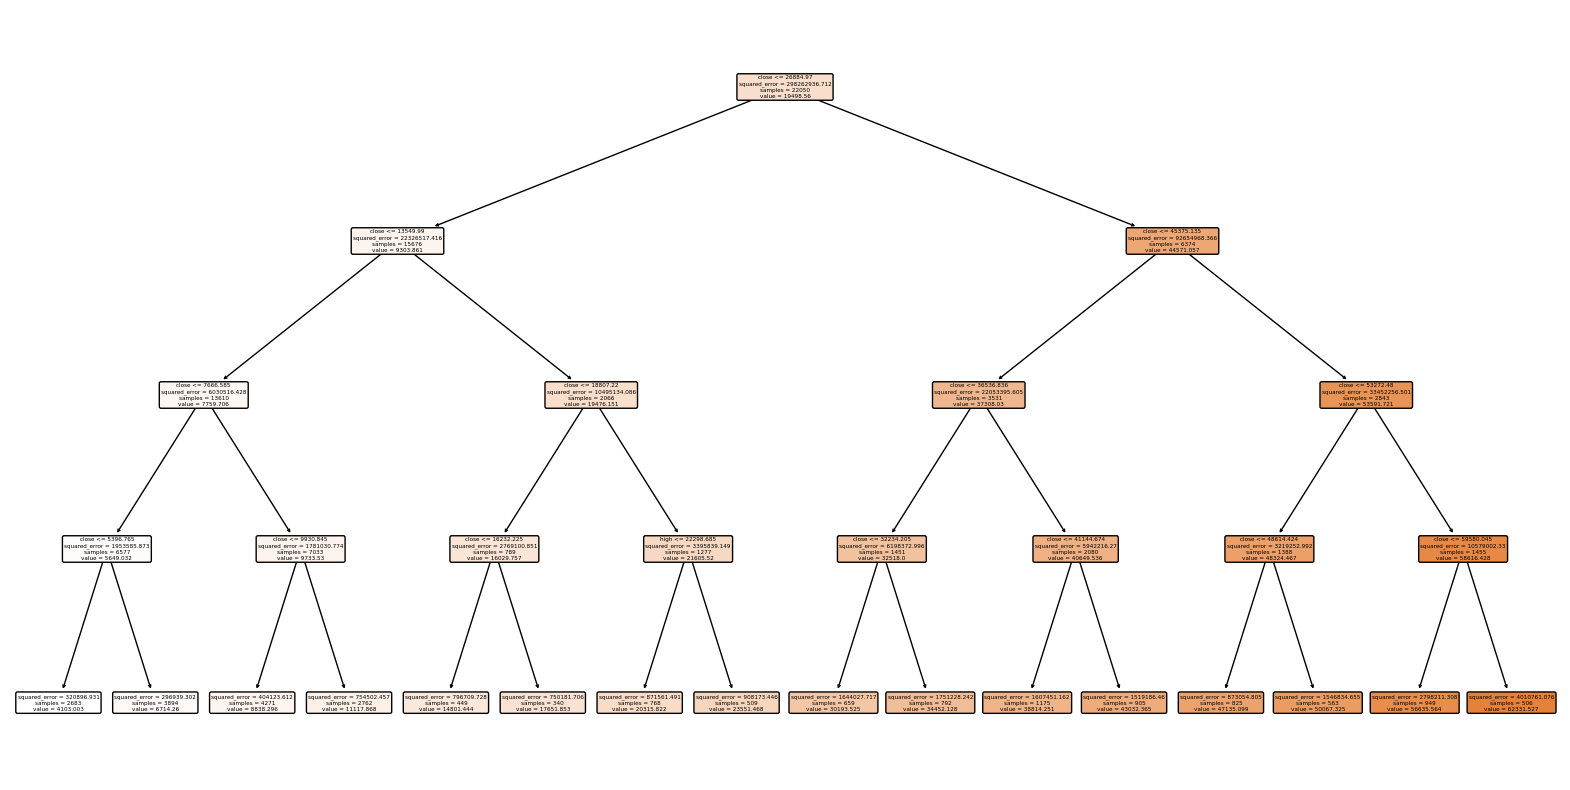

In [113]:
dt = DecisionTreeRegressor(max_depth=4,
                            min_samples_leaf=100,
                            min_impurity_decrease=0.01,
                            random_state=42)
dt.fit(X_train, y_train)
plt.figure(figsize=(20,10))
plot_tree(dt, filled=True, feature_names=list(X.columns), rounded=True)
plt.show()

#### Best Models

In [114]:
# Create TimeSeriesSplit object
tscv = TimeSeriesSplit(n_splits=15, test_size=3)

knn = Pipeline([
    ('scale', MinMaxScaler()),
    ('knn', KNeighborsRegressor(n_neighbors=8, p=1, n_jobs=-1, weights='distance'))
])

en_pipe = Pipeline([
    ('scaler', StandardScaler()),
    ('en', ElasticNet(max_iter=100_000,l1_ratio=0.8, alpha=0.1))
])

# Models to try in each cross-validation split
models = [
   LinearRegression(n_jobs=-1),
   knn,
   GradientBoostingRegressor(max_depth=5, learning_rate=0.09, criterion='friedman_mse', n_estimators=100, min_samples_leaf=5, min_samples_split=15, max_features=0.8),
   en_pipe
]


train_maes, valid_maes, train_mse, valid_mse, train_medae, valid_medae, best_pa, valid_bacc, valid_prec, valid_rec = custom_cv_ts(df2, models, X2_train, y2_train, cv=tscv)

0
Best validation model: 0
Train dates: 2017-08-17 - 2022-08-29
Train MAE: 154.9
Train MSE: 92952.01
Train MedAE: 54.62
Validation dates: 2022-08-29 - 2022-08-29
Validation MAE: 151.07
Validation MSE: 31400.8
Validation MedAE: 177.52
Validation BACC: 0.49684927208317164
Validation PREC: 0.4919431279620853
Validation REC: 0.4761467889908257

1
Best validation model: 0
Train dates: 2017-08-17 - 2022-08-29
Train MAE: 154.9
Train MSE: 92943.61
Train MedAE: 54.6
Validation dates: 2022-08-29 - 2022-08-29
Validation MAE: 93.93
Validation MSE: 13298.68
Validation MedAE: 94.33
Validation BACC: 0.49642158198528497
Validation PREC: 0.49195837275307475
Validation REC: 0.4766269477543538

2
Best validation model: 0
Train dates: 2017-08-17 - 2022-08-29
Train MAE: 154.9
Train MSE: 92932.75
Train MedAE: 54.61
Validation dates: 2022-08-29 - 2022-08-30
Validation MAE: 102.37
Validation MSE: 10612.79
Validation MedAE: 100.49
Validation BACC: 0.4971058517400778
Validation PREC: 0.49245283018867925
Validat

In [115]:
print('Mean train MAE:', train_maes.mean().round(2), '$')
print('Mean validation MAE:', valid_maes.mean().round(2), '$')
print()
print('Mean train MSE:', train_mse.mean().round(2), '$')
print('Mean validation MSE:', valid_mse.mean().round(2), '$')
print()
print('Mean train MedAE:', train_medae.mean().round(2), '$')
print('Mean validation MedAE:', valid_medae.mean().round(2), '$')
print()
print('Mean validation Bacc:', valid_bacc.mean().round(2), '%')
print()
print('Mean validation Prec:', valid_prec.mean().round(2), '%')
print()
print('Mean validation Rec:', valid_rec.mean().round(2), '%')
print()
print(best_pa)

Mean train MAE: 154.88 $
Mean validation MAE: 125.45 $

Mean train MSE: 92891.17 $
Mean validation MSE: 25939.21 $

Mean train MedAE: 54.64 $
Mean validation MedAE: 111.11 $

Mean validation Bacc: 0.5 %

Mean validation Prec: 0.49 %

Mean validation Rec: 0.48 %

[]


In [116]:
# Create TimeSeriesSplit object
tscv = TimeSeriesSplit(n_splits=15, test_size=7)

knn = Pipeline([
    ('scale', MinMaxScaler()),
    ('knn', KNeighborsRegressor(n_neighbors=8, p=1, n_jobs=-1, weights='distance'))
])

en_pipe = Pipeline([
    ('scaler', StandardScaler()),
    ('en', ElasticNet(max_iter=100_000,l1_ratio=0.8, alpha=0.1))
])

# Models to try in each cross-validation split
models = [
   LinearRegression(n_jobs=-1),
   knn,
   GradientBoostingRegressor(max_depth=5, learning_rate=0.09, criterion='friedman_mse', n_estimators=100, min_samples_leaf=5, min_samples_split=15, max_features=0.8),
   en_pipe
]


train_maes, valid_maes, train_mse, valid_mse, train_medae, valid_medae, best_pa, valid_bacc, valid_prec, valid_rec = custom_cv_ts(df2, models, X2_train, y2_train, cv=tscv)

0
Best validation model: 0
Train dates: 2017-08-17 - 2022-08-24
Train MAE: 155.04
Train MSE: 93105.48
Train MedAE: 54.57
Validation dates: 2022-08-24 - 2022-08-24
Validation MAE: 103.21
Validation MSE: 16832.03
Validation MedAE: 112.14
Validation BACC: 0.4955790784557908
Validation PREC: 0.49404761904761907
Validation REC: 0.4547945205479452

1
Best validation model: 0
Train dates: 2017-08-17 - 2022-08-24
Train MAE: 155.02
Train MSE: 93081.16
Train MedAE: 54.58
Validation dates: 2022-08-25 - 2022-08-25
Validation MAE: 82.7
Validation MSE: 11346.46
Validation MedAE: 76.02
Validation BACC: 0.4972333346881187
Validation PREC: 0.496551724137931
Validation REC: 0.4594348222424795

2
Best validation model: 0
Train dates: 2017-08-17 - 2022-08-25
Train MAE: 155.0
Train MSE: 93055.1
Train MedAE: 54.56
Validation dates: 2022-08-25 - 2022-08-26
Validation MAE: 41.15
Validation MSE: 4049.87
Validation MedAE: 19.93
Validation BACC: 0.497691611583581
Validation PREC: 0.49706457925636005
Validation R

In [117]:
print('Mean train MAE:', train_maes.mean().round(2), '$')
print('Mean validation MAE:', valid_maes.mean().round(2), '$')
print()
print('Mean train MSE:', train_mse.mean().round(2), '$')
print('Mean validation MSE:', valid_mse.mean().round(2), '$')
print()
print('Mean train MedAE:', train_medae.mean().round(2), '$')
print('Mean validation MedAE:', valid_medae.mean().round(2), '$')
print()
print('Mean validation Bacc:', valid_bacc.mean().round(2), '%')
print()
print('Mean validation Prec:', valid_prec.mean().round(2), '%')
print()
print('Mean validation Rec:', valid_rec.mean().round(2), '%')
print()
print(best_pa)

Mean train MAE: 154.94 $
Mean validation MAE: 117.34 $

Mean train MSE: 92979.61 $
Mean validation MSE: 32245.47 $

Mean train MedAE: 54.6 $
Mean validation MedAE: 95.05 $

Mean validation Bacc: 0.5 %

Mean validation Prec: 0.49 %

Mean validation Rec: 0.47 %

[]


#### RNNs

In [78]:
def create_data_for_rnns(X2, y2, look_back=4):
    dataX, dataY = [], []
    for i in range(len(X) - look_back):
        # Take sequence of length `look_back`
        seqX = X.iloc[i:(i + look_back)].values
        seqY = y.iloc[i:(i + look_back)].values
        dataX.append(seqX)
        dataY.append(seqY)
    return np.array(dataX), np.array(dataY)

In [79]:
X_train_rnn2, y_train_rnn2 = create_data_for_rnns(X_train, y_train, look_back=3)

# Añadir corrección para que tenga el mismo tamaño que X_train_raw
# de esta manera, la validación cruzada se aplicará en los mismos días que antes
X_train_rnn = np.concatenate((X_train_rnn, np.zeros((3, 3, X_train_rnn.shape[2]))), axis=0)
y_train_rnn = np.concatenate((y_train_rnn, np.zeros((3, 3))), axis=0)

pd.DataFrame(X_train_rnn[1], columns=X_train.columns)

open     high      low    close     volume          quote  trades  \
0  4330.29  4349.99  4287.41  4349.99  11.672940   50523.370970    61.0   
1  4333.32  4445.78  4333.32  4444.00  11.736430   51458.859529    71.0   
2  4441.10  4485.39  4399.81  4427.30  51.883452  231042.298220   177.0   

   takers_buy_base  takers_buy_quote  
0         7.405153      32086.664239  
1        11.073055      48548.124975  
2        47.714578     212505.926179

##### GRU

In [82]:
gru = Sequential([
    Input(shape=(X_train_rnn2.shape[1], X_train_rnn2.shape[2])),
    Normalization(),
    GRU(32, return_sequences=True),
    #GRU(32, return_sequences=True),
    GRU(16, return_sequences=False),
    Dense(8, activation='relu'),
    Dense(4, activation='relu'),
    Dense(1, activation='linear')
])
gru.compile(optimizer=Adam(learning_rate=0.001), loss='mae')
es = EarlyStopping(patience=15, monitor='loss', restore_best_weights=True)

In [83]:
# Create TimeSeriesSplit object
tscv = TimeSeriesSplit(n_splits=15, test_size=3)

# Models to try in each cross-validation split
models = [gru]
fit_hyperparams = {
    'epochs': 500,
    'batch_size': 248,
    'validation_split': 0.25,
    'callbacks': [es],
    'verbose': 0,
}

train_maes, valid_maes, valid_bacc, valid_prec, valid_rec = custom_cv_ts_rnn(df2, models, X_train_rnn2, y_train_rnn2, cv=tscv,
                                          fit_hyperparams=fit_hyperparams, dates=dates)

KeyboardInterrupt: 

In [ ]:
print('Mean train MAE:', train_maes.mean().round(2), '$')
print('Mean validation MAE:', valid_maes.mean().round(2), '$')
print('Median validation MAE:', np.median(valid_maes).round(2), '$')
'''print()
print('Mean validation Bacc:', valid_bacc.mean().round(2), '%')
print()
print('Mean validation Prec:', valid_prec.mean().round(2), '%')
print()
print('Mean validation Rec:', valid_rec.mean().round(2), '%')
print()'''

NameError: name 'train_maes' is not defined

### Test

#### Best Models

In [47]:
lr = LinearRegression(n_jobs=-1)
lr.fit(X2_train, y2_train)

LinearRegression(n_jobs=-1)

In [48]:
y_diff = y2_test - X2_test.close
y_diff
y_real_bin = pd.Series(np.zeros(len(y2_test)))
y_real_bin.iloc[np.where(y_diff > 0)[0]] = 1

y_pred = lr.predict(X2_test)
y_diff = y_pred - X2_test.close
y_diff
y_pred_bin = pd.Series(np.zeros(len(y2_test)))
y_pred_bin.iloc[np.where(y_diff > 0)[0]] = 1 

In [50]:
print("Test Bacc:", balanced_accuracy_score(y_real_bin, y_pred_bin))
print("Test Prec:", precision_score(y_real_bin, y_pred_bin))
print("Test Rec:", recall_score(y_real_bin, y_pred_bin))

Test Bacc: 0.5381332651694313
Test Prec: 0.5678947368421052
Test Rec: 0.38181174805378626


In [51]:
y_diff = y2 - X2.close
y_diff
y_real_bin = pd.Series(np.zeros(len(y2)))
y_real_bin.iloc[np.where(y_diff > 0)[0]] = 1

y_pred = lr.predict(X2)
y_diff = y_pred - X2.close
y_diff
y_pred_bin = pd.Series(np.zeros(len(y2)))
y_pred_bin.iloc[np.where(y_diff > 0)[0]] = 1 

In [52]:
print("Test Bacc:", balanced_accuracy_score(y_real_bin, y_pred_bin))
print("Test Prec:", precision_score(y_real_bin, y_pred_bin))
print("Test Rec:", recall_score(y_real_bin, y_pred_bin))

Test Bacc: 0.5463318884636483
Test Prec: 0.5653043269615292
Test Rec: 0.49862433862433864


In [53]:
tscv = TimeSeriesSplit(n_splits=15, test_size=3)
lr = LinearRegression(n_jobs=-1)
lr_cv = cross_validate(lr, X2_train, y2_train, cv=tscv, 
                       scoring=scoring, return_train_score=True)


In [54]:
tscv = TimeSeriesSplit(n_splits=15, test_size=3)

param_dist = {
   
}

lr = LinearRegression(n_jobs=-1)

lr_rscv = RandomizedSearchCV(lr, param_distributions=param_dist,
                              return_train_score=True,
                              cv=tscv,
                              n_jobs=-1)

lr_rscv.fit(X2_train, y2_train)

c:\Users\Alumne_mati1\anaconda3\Lib\site-packages\sklearn\model_selection\_search.py:307: UserWarning: The total space of parameters 1 is smaller than n_iter=10. Running 1 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


RandomizedSearchCV(cv=TimeSeriesSplit(gap=0, max_train_size=None, n_splits=15, test_size=3),
                   estimator=LinearRegression(n_jobs=-1), n_jobs=-1,
                   param_distributions={}, return_train_score=True)

In [55]:
y_diff = y2_test - X2_test.close
y_diff
y_real_bin = pd.Series(np.zeros(len(y2_test)))
y_real_bin.iloc[np.where(y_diff > 0)[0]] = 1

y_pred = lr_rscv.predict(X2_test)
y_diff = y_pred - X2_test.close
y_diff
y_pred_bin = pd.Series(np.zeros(len(y2_test)))
y_pred_bin.iloc[np.where(y_diff > 0)[0]] = 1 

In [56]:
print("Test Bacc:", balanced_accuracy_score(y_real_bin, y_pred_bin))
print("Test Prec:", precision_score(y_real_bin, y_pred_bin))
print("Test Rec:", recall_score(y_real_bin, y_pred_bin))

Test Bacc: 0.5381332651694313
Test Prec: 0.5678947368421052
Test Rec: 0.38181174805378626


In [57]:
y_diff = y2 - X2.close
y_diff
y_real_bin = pd.Series(np.zeros(len(y2)))
y_real_bin.iloc[np.where(y_diff > 0)[0]] = 1

y_pred = lr_rscv.predict(X2)
y_diff = y_pred - X2.close
y_diff
y_pred_bin = pd.Series(np.zeros(len(y2)))
y_pred_bin.iloc[np.where(y_diff > 0)[0]] = 1 

In [58]:
print("Test Bacc:", balanced_accuracy_score(y_real_bin, y_pred_bin))
print("Test Prec:", precision_score(y_real_bin, y_pred_bin))
print("Test Rec:", recall_score(y_real_bin, y_pred_bin))

Test Bacc: 0.5463318884636483
Test Prec: 0.5653043269615292
Test Rec: 0.49862433862433864


##### test size = 3

In [118]:
# Create TimeSeriesSplit object
tscv = TimeSeriesSplit(n_splits=15, test_size=3)

knn = Pipeline([
    ('scale', MinMaxScaler()),
    ('knn', KNeighborsRegressor(n_neighbors=8, p=1, n_jobs=-1, weights='distance'))
])

en_pipe = Pipeline([
    ('scaler', StandardScaler()),
    ('en', ElasticNet(max_iter=100_000,l1_ratio=0.8, alpha=0.1))
])

# Models to try in each cross-validation split
models = [
   LinearRegression(n_jobs=-1),
   knn,
   GradientBoostingRegressor(max_depth=5, learning_rate=0.09, criterion='friedman_mse', n_estimators=100, min_samples_leaf=5, min_samples_split=15, max_features=0.8),
   en_pipe
]


train_maes, valid_maes, train_mse, valid_mse, train_medae, valid_medae, best_pa, valid_bacc, valid_prec, valid_rec = custom_cv_ts(df2, models, X2, y2, cv=tscv)

0
Best validation model: 0
Train dates: 2017-08-17 - 2023-12-01
Train MAE: 143.21
Train MSE: 79793.87
Train MedAE: 54.39
Validation dates: 2023-12-01 - 2023-12-01
Validation MAE: 55.57
Validation MSE: 3923.67
Validation MedAE: 70.9
Validation BACC: 0.5102971144925582
Validation PREC: 0.5697674418604651
Validation REC: 0.10374029640084687

1
Best validation model: 0
Train dates: 2017-08-17 - 2023-12-01
Train MAE: 143.2
Train MSE: 79785.6
Train MedAE: 54.39
Validation dates: 2023-12-02 - 2023-12-02
Validation MAE: 34.96
Validation MSE: 1404.2
Validation MedAE: 41.85
Validation BACC: 0.5103282320327588
Validation PREC: 0.5697674418604651
Validation REC: 0.10374029640084687

2
Best validation model: 0
Train dates: 2017-08-17 - 2023-12-02
Train MAE: 143.18
Train MSE: 79777.06
Train MedAE: 54.38
Validation dates: 2023-12-02 - 2023-12-02
Validation MAE: 60.41
Validation MSE: 4462.02
Validation MedAE: 78.81
Validation BACC: 0.5100428271406175
Validation PREC: 0.5680933852140078
Validation REC:

In [119]:
print('Mean train MAE:', train_maes.mean().round(2), '$')
print('Mean test MAE:', valid_maes.mean().round(2), '$')
print()
print('Mean train MSE:', train_mse.mean().round(2), '$')
print('Mean test MSE:', valid_mse.mean().round(2), '$')
print()
print('Mean train MedAE:', train_medae.mean().round(2), '$')
print('Mean test MedAE:', valid_medae.mean().round(2), '$')
print()
print('Mean test Bacc:', valid_bacc.mean().round(2), '%')
print()
print('Mean test Prec:', valid_prec.mean().round(2), '%')
print()
print('Mean test Rec:', valid_rec.mean().round(2), '%')
print()
print(best_pa)

Mean train MAE: 143.19 $
Mean test MAE: 151.65 $

Mean train MSE: 79767.24 $
Mean test MSE: 55247.76 $

Mean train MedAE: 54.39 $
Mean test MedAE: 107.48 $

Mean test Bacc: 0.51 %

Mean test Prec: 0.57 %

Mean test Rec: 0.1 %

[]


##### test size = 7

In [120]:
# Create TimeSeriesSplit object
tscv = TimeSeriesSplit(n_splits=15, test_size=7)

knn = Pipeline([
    ('scale', MinMaxScaler()),
    ('knn', KNeighborsRegressor(n_neighbors=8, p=1, n_jobs=-1, weights='distance'))
])

en_pipe = Pipeline([
    ('scaler', StandardScaler()),
    ('en', ElasticNet(max_iter=100_000,l1_ratio=0.8, alpha=0.1))
])

# Models to try in each cross-validation split
models = [
   LinearRegression(n_jobs=-1),
   knn,
   GradientBoostingRegressor(max_depth=5, learning_rate=0.09, criterion='friedman_mse', n_estimators=100, min_samples_leaf=5, min_samples_split=15, max_features=0.8),
   en_pipe
]


train_maes, valid_maes, train_mse, valid_mse, train_medae, valid_medae, best_pa, valid_bacc, valid_prec, valid_rec = custom_cv_ts(df2, models, X2, y2, cv=tscv)

0
Best validation model: 0
Train dates: 2017-08-17 - 2023-11-26
Train MAE: 143.21
Train MSE: 79891.4
Train MedAE: 54.24
Validation dates: 2023-11-26 - 2023-11-27
Validation MAE: 102.43
Validation MSE: 17659.1
Validation MedAE: 89.19
Validation BACC: 0.5097332031289411
Validation PREC: 0.5675675675675675
Validation REC: 0.10374029640084687

1
Best validation model: 0
Train dates: 2017-08-17 - 2023-11-27
Train MAE: 143.2
Train MSE: 79875.54
Train MedAE: 54.24
Validation dates: 2023-11-27 - 2023-11-27
Validation MAE: 171.01
Validation MSE: 36525.2
Validation MedAE: 171.95
Validation BACC: 0.5097648850425287
Validation PREC: 0.5675675675675675
Validation REC: 0.10374029640084687

2
Best validation model: 0
Train dates: 2017-08-17 - 2023-11-27
Train MAE: 143.2
Train MSE: 79864.49
Train MedAE: 54.26
Validation dates: 2023-11-27 - 2023-11-28
Validation MAE: 122.6
Validation MSE: 21060.8
Validation MedAE: 173.13
Validation BACC: 0.5101721767503858
Validation PREC: 0.5697674418604651
Validation

In [121]:
print('Mean train MAE:', train_maes.mean().round(2), '$')
print('Mean test MAE:', valid_maes.mean().round(2), '$')
print()
print('Mean train MSE:', train_mse.mean().round(2), '$')
print('Mean test MSE:', valid_mse.mean().round(2), '$')
print()
print('Mean train MedAE:', train_medae.mean().round(2), '$')
print('Mean test MedAE:', valid_medae.mean().round(2), '$')
print()
print('Mean test Bacc:', valid_bacc.mean().round(2), '%')
print()
print('Mean test Prec:', valid_prec.mean().round(2), '%')
print()
print('Mean test Rec:', valid_rec.mean().round(2), '%')
print()
print(best_pa)

Mean train MAE: 143.2 $
Mean test MAE: 146.79 $

Mean train MSE: 79812.47 $
Mean test MSE: 43775.75 $

Mean train MedAE: 54.34 $
Mean test MedAE: 113.58 $

Mean test Bacc: 0.51 %

Mean test Prec: 0.57 %

Mean test Rec: 0.1 %

[]


## Save Model

In [59]:
import pickle

In [60]:
lr = LinearRegression(n_jobs=-1)
lr.fit(X2, y2)

LinearRegression(n_jobs=-1)

In [61]:
with open('model_lr_predict_bitcoin.pkl', 'wb') as f:
    pickle.dump(lr, f)

## Load Model

In [62]:
with open('model_lr_predict_bitcoin.pkl', 'rb') as f:
    lr_load = pickle.load(f)

In [63]:
y_diff = y2 - X2.close
y_diff
y_real_bin = pd.Series(np.zeros(len(y2)))
y_real_bin.iloc[np.where(y_diff > 0)[0]] = 1

y_pred = lr_load.predict(X2)
y_diff = y_pred - X2.close
y_diff
y_pred_bin = pd.Series(np.zeros(len(y2)))
y_pred_bin.iloc[np.where(y_diff > 0)[0]] = 1 

In [64]:
print("Test Bacc:", balanced_accuracy_score(y_real_bin, y_pred_bin))
print("Test Prec:", precision_score(y_real_bin, y_pred_bin))
print("Test Rec:", recall_score(y_real_bin, y_pred_bin))

Test Bacc: 0.543297111472592
Test Prec: 0.5580865603644647
Test Rec: 0.5358024691358024
